## Creating a Stochastic Model Benchmark

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import t, rankdata
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import os

!pip install python-dotenv
!pip install copulae
from dotenv.main import load_dotenv

load_dotenv(override=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 19.1 MB/s eta 0:00:00


False

In [3]:
#from drive.MyDrive.MasterThesis.hybrid_mc import MonteCarloJumpGBM
from drive.MyDrive.MasterThesis.stochasticClayton import MonteCarloJumpGBM

In [4]:

assets_0 = 1000000
liabilities_0 = 1000000 * 0.88
num_simulations = 10000
bof_0 = assets_0 - liabilities_0

In [5]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('drive/MyDrive/MasterThesis/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = '2020-01-01'

    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0,1,2,3,4,5,6]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:]

    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [6]:
returns_df.head()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2005-10-11,0.003231,0.006833,0.004578,-0.001342,-0.001916,-0.004075,0.000054
2005-10-12,-0.003550,-0.009657,-0.007867,-0.002606,-0.001570,-0.004370,0.000058
2005-10-13,-0.018599,-0.010692,0.000588,-0.002331,-0.003062,-0.003423,0.000058
2005-10-14,-0.007856,0.001569,-0.002991,-0.000564,0.000060,0.001618,0.000058
2005-10-17,-0.003613,0.000492,0.003290,0.000458,-0.000227,0.005447,0.000173


In [7]:
asset_names = returns_df.columns
#weights = np.array([0.07, 0.05, 0.2, 0.21, 0.26, 0.15, 0.06])

weights = np.array([0.07, 0.01, 0.18, 0.26, 0.34, 0.07, 0.07])
np.sum(weights)

np.float64(1.0000000000000002)

In [8]:
entire_df = pd.concat([returns_df, test_returns_df])

test_start_date = test_returns_df.index.min()
test_end_date = test_returns_df.index.max()
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)
historical_df = entire_df.iloc[idx_start - 252:]
#historical_df= historical_df.iloc[:504]

historical_df.head()

eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

In [9]:
a = historical_df.iloc[:253]
a.tail()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2019-12-24,0.003047,0.001789,0.000329,0.001135,-0.000096,0.000122,-0.000015
2019-12-27,0.012164,0.003310,-0.000870,0.001971,0.001809,0.000789,-0.000015
2019-12-30,-0.004847,-0.005184,-0.008396,-0.001701,-0.004516,0.000307,-0.000045
2019-12-31,0.002186,-0.000405,0.000325,-0.000746,0.000056,0.000160,-0.000015
2020-01-02,0.004894,0.006604,0.009625,0.002157,0.002519,0.001449,-0.000015


# Creating Testing Data

In [10]:
n_windows = len(historical_df) - 252 + 1

window_start_dates = []
window_end_dates = []
realized_delta_bof_values_1 = []

for t in range(n_windows):
    # Get window data
    window_data = historical_df.iloc[t:t+252]
    window_start_date = historical_df.index[t]
    window_end_date = historical_df.index[t+252-1]

    # Get returns and EONIA for this window
    window_returns = (window_data * weights).sum(axis=1)
    window_eonia = window_data.iloc[:, -1]

    # Calculate portfolio value at the end of the window
    # Starting from assets_0 each time
    portfolio_value_end = assets_0 * (1 + window_returns).prod() # This is analogous to the yearly return

    # Calculate liabilities at the end of the window
    # Starting from liabilities_0 each time
    liabilities_end = liabilities_0 * (1 + window_eonia).prod()

    # Calculate BOF at the end of the window
    bof_end = portfolio_value_end - liabilities_end
    delta_bof = bof_end - bof_0

    # Store results
    window_start_dates.append(window_start_date)
    window_end_dates.append(window_end_date)
    realized_delta_bof_values_1.append(delta_bof)

## Concatonating all Stochastic Models

Plan
1. Same GBM with jumps model for all assets
2. Special Model for EONIA
3. Use some Copula --> Use Student-t Copula

Uncomment if you want to test some stuff

## Generating all test SCRs

In [11]:
entire_df = pd.concat([returns_df, test_returns_df])

slice_start_row = max(0, len(returns_df) - 252)

slice_end_row = max(slice_start_row, len(entire_df) - 252)

new_df = entire_df.iloc[slice_start_row:slice_end_row]

In [12]:
scenarios_results = {}
portfolio_scr_results = {}
lookback = 252 + 30

kappa = None

i = 0
for i, t in enumerate(tqdm(new_df.index, desc='Processing Dates', unit='Date')):
    t_position = entire_df.index.get_loc(t)
    i += 1

    window_data = entire_df.iloc[:t_position] #historical_df.iloc[t_position-lookback:t_position]

    if i == 1:
      mc_model = MonteCarloJumpGBM(window_data, weights)
      kappa = mc_model.kappa
      print("KAPPA =", kappa)
    else:
      mc_model = MonteCarloJumpGBM(window_data, weights, kappa=kappa)

    scr = mc_model.calculate_scr()['scr']

    if t != test_returns_df.index[-1]:
        next_day = new_df.index[new_df.index.get_loc(t) + 1]
    else:
        print(f"Warning: {t} is the last day in the index, no next day available.")
        continue

    if scr > 0: scr = 0.0

    portfolio_scr_results[next_day] = scr

    print(scr)

Processing Dates:   0%|          | 0/1232 [00:00<?, ?Date/s]

KAPPA = None


Processing Dates:   0%|          | 1/1232 [00:06<2:06:38,  6.17s/Date]

-140688.87852630462


Processing Dates:   0%|          | 3/1232 [00:06<31:33,  1.54s/Date]

-140627.67323356477
-143043.87109364755


Processing Dates:   0%|          | 5/1232 [00:06<14:37,  1.40Date/s]

-139583.56649753873
-136283.7896060907


Processing Dates:   0%|          | 6/1232 [00:07<11:00,  1.85Date/s]

-139039.88452768663


Processing Dates:   1%|          | 7/1232 [00:07<08:52,  2.30Date/s]

-137805.9907160601


Processing Dates:   1%|          | 8/1232 [00:07<07:39,  2.66Date/s]

-141655.34853778133


Processing Dates:   1%|          | 9/1232 [00:07<06:58,  2.92Date/s]

-137382.16019158813


Processing Dates:   1%|          | 10/1232 [00:08<06:34,  3.10Date/s]

-145107.1425274124


Processing Dates:   1%|          | 11/1232 [00:08<06:10,  3.30Date/s]

-139004.11740707175


Processing Dates:   1%|          | 12/1232 [00:08<05:59,  3.39Date/s]

-137475.46480797426


Processing Dates:   1%|          | 13/1232 [00:08<05:46,  3.52Date/s]

-138062.90551826943


Processing Dates:   1%|          | 14/1232 [00:09<05:33,  3.65Date/s]

-136688.77497292848


Processing Dates:   1%|          | 15/1232 [00:09<05:33,  3.65Date/s]

-136765.82469741793


Processing Dates:   1%|▏         | 16/1232 [00:09<05:29,  3.69Date/s]

-140368.38864456085


Processing Dates:   1%|▏         | 17/1232 [00:10<05:28,  3.70Date/s]

-136828.57331979772


Processing Dates:   1%|▏         | 18/1232 [00:10<05:31,  3.66Date/s]

-136784.1923546513


Processing Dates:   2%|▏         | 19/1232 [00:10<05:36,  3.60Date/s]

-141607.0070188215


Processing Dates:   2%|▏         | 20/1232 [00:10<05:38,  3.58Date/s]

-135511.47113408192


Processing Dates:   2%|▏         | 21/1232 [00:11<05:29,  3.68Date/s]

-139898.91021722308


Processing Dates:   2%|▏         | 22/1232 [00:11<05:29,  3.67Date/s]

-137854.80390031665


Processing Dates:   2%|▏         | 23/1232 [00:11<05:37,  3.58Date/s]

-141251.24443647446


Processing Dates:   2%|▏         | 24/1232 [00:11<05:39,  3.56Date/s]

-139001.3446004934


Processing Dates:   2%|▏         | 25/1232 [00:12<05:34,  3.61Date/s]

-136132.35325173856


Processing Dates:   2%|▏         | 26/1232 [00:12<05:32,  3.63Date/s]

-137066.3713555544


Processing Dates:   2%|▏         | 27/1232 [00:12<05:29,  3.66Date/s]

-140068.81340818026


Processing Dates:   2%|▏         | 28/1232 [00:13<05:25,  3.70Date/s]

-137588.91425990398
-139336.7230327801


Processing Dates:   3%|▎         | 31/1232 [00:13<04:22,  4.57Date/s]

-138975.47161824035
-135854.6629180964


Processing Dates:   3%|▎         | 33/1232 [00:14<04:05,  4.88Date/s]

-135197.50413003456
-135997.25788163513


Processing Dates:   3%|▎         | 35/1232 [00:14<03:59,  5.00Date/s]

-141638.92572497495
-140182.16500051424


Processing Dates:   3%|▎         | 37/1232 [00:14<03:56,  5.06Date/s]

-133410.51343027304
-141529.2142478955


Processing Dates:   3%|▎         | 39/1232 [00:15<03:52,  5.14Date/s]

-139440.86620079947
-147351.3673579925


Processing Dates:   3%|▎         | 41/1232 [00:15<03:51,  5.14Date/s]

-136253.6773354024
-136248.4762333675


Processing Dates:   3%|▎         | 43/1232 [00:15<03:51,  5.13Date/s]

-132199.0671512158
-133636.22260090004


Processing Dates:   4%|▎         | 45/1232 [00:16<03:51,  5.12Date/s]

-140023.16043211022
-136415.6192865247


Processing Dates:   4%|▎         | 46/1232 [00:16<03:59,  4.95Date/s]

-132695.0517765502


Processing Dates:   4%|▍         | 47/1232 [00:16<04:11,  4.70Date/s]

-138811.08546735492


Processing Dates:   4%|▍         | 48/1232 [00:17<04:34,  4.32Date/s]

-136179.10899442114


Processing Dates:   4%|▍         | 49/1232 [00:17<04:33,  4.33Date/s]

-135113.0567248438


Processing Dates:   4%|▍         | 50/1232 [00:17<04:28,  4.39Date/s]

-139308.9710904199


Processing Dates:   4%|▍         | 51/1232 [00:17<04:36,  4.27Date/s]

-141841.2577786487


Processing Dates:   4%|▍         | 52/1232 [00:18<04:45,  4.13Date/s]

-137208.3699388668


Processing Dates:   4%|▍         | 53/1232 [00:18<04:35,  4.29Date/s]

-135504.22696040318


Processing Dates:   4%|▍         | 54/1232 [00:18<04:31,  4.33Date/s]

-136333.5144822648


Processing Dates:   4%|▍         | 55/1232 [00:18<04:25,  4.43Date/s]

-131220.65906692093


Processing Dates:   5%|▍         | 56/1232 [00:18<04:18,  4.54Date/s]

-136172.78339534355
-135111.03490971314


Processing Dates:   5%|▍         | 59/1232 [00:19<04:02,  4.85Date/s]

-137015.41774143142
-141397.97116550503


Processing Dates:   5%|▍         | 60/1232 [00:19<03:59,  4.89Date/s]

-134620.45791046042


Processing Dates:   5%|▍         | 61/1232 [00:19<04:02,  4.83Date/s]

-133701.21831189888
-135745.77171156608


Processing Dates:   5%|▌         | 64/1232 [00:20<03:54,  4.99Date/s]

-137663.23866381156
-136453.56134689576


Processing Dates:   5%|▌         | 66/1232 [00:20<03:52,  5.02Date/s]

-131521.37022863977
-135815.31038164266


Processing Dates:   5%|▌         | 67/1232 [00:21<03:50,  5.06Date/s]

-134719.12491806658
-136276.3518050668


Processing Dates:   6%|▌         | 70/1232 [00:21<03:49,  5.07Date/s]

-135516.60208794364
-133598.99530296584


Processing Dates:   6%|▌         | 72/1232 [00:22<03:44,  5.16Date/s]

-132922.57958843
-136879.55709350988


Processing Dates:   6%|▌         | 74/1232 [00:22<03:40,  5.24Date/s]

-138039.04753579965
-143018.7652333155


Processing Dates:   6%|▌         | 76/1232 [00:22<03:43,  5.17Date/s]

-138458.08274501262
-129440.00510636516


Processing Dates:   6%|▋         | 78/1232 [00:23<03:45,  5.13Date/s]

-138285.58722072153
-134385.08645441238


Processing Dates:   6%|▋         | 80/1232 [00:23<03:42,  5.19Date/s]

-134024.10560066524
-133367.40851108477


Processing Dates:   7%|▋         | 82/1232 [00:24<03:41,  5.18Date/s]

-136370.27854481206
-134054.82358692438


Processing Dates:   7%|▋         | 84/1232 [00:24<03:41,  5.18Date/s]

-133231.2188191757
-135851.26499976104


Processing Dates:   7%|▋         | 85/1232 [00:24<03:41,  5.18Date/s]

-130452.0981208643
-138607.91634337098


Processing Dates:   7%|▋         | 88/1232 [00:25<03:43,  5.11Date/s]

-131573.59552014837
-135444.85859354175


Processing Dates:   7%|▋         | 90/1232 [00:25<03:44,  5.10Date/s]

-134313.04892579227
-132346.4253859446


Processing Dates:   7%|▋         | 92/1232 [00:25<03:43,  5.11Date/s]

-130240.05017899838
-135530.4190469506


Processing Dates:   8%|▊         | 94/1232 [00:26<03:43,  5.10Date/s]

-133408.311286453
-130178.34394682907


Processing Dates:   8%|▊         | 96/1232 [00:26<03:40,  5.16Date/s]

-137697.3150753241
-131447.65909604146


Processing Dates:   8%|▊         | 98/1232 [00:27<03:43,  5.07Date/s]

-138526.52691026678
-136486.02762762978


Processing Dates:   8%|▊         | 99/1232 [00:27<03:48,  4.96Date/s]

-134393.78055427046
-131784.71786218818


Processing Dates:   8%|▊         | 102/1232 [00:27<03:43,  5.05Date/s]

-134911.45442716213
-134265.98068138675


Processing Dates:   8%|▊         | 104/1232 [00:28<03:41,  5.10Date/s]

-136906.69871405704
-138113.6800371653


Processing Dates:   9%|▊         | 106/1232 [00:28<03:40,  5.11Date/s]

-133808.41798626733
-133510.0296126174


Processing Dates:   9%|▉         | 108/1232 [00:29<03:44,  5.01Date/s]

-137812.79061641014
-134117.5464152024


Processing Dates:   9%|▉         | 109/1232 [00:29<03:47,  4.94Date/s]

-131689.36729674196


Processing Dates:   9%|▉         | 110/1232 [00:29<04:05,  4.57Date/s]

-133978.84178609788


Processing Dates:   9%|▉         | 111/1232 [00:29<04:21,  4.28Date/s]

-133616.92013140986


Processing Dates:   9%|▉         | 112/1232 [00:30<04:24,  4.24Date/s]

-140079.53508186364


Processing Dates:   9%|▉         | 113/1232 [00:30<04:32,  4.10Date/s]

-130989.81676994408


Processing Dates:   9%|▉         | 114/1232 [00:30<04:37,  4.03Date/s]

-141858.0003482006


Processing Dates:   9%|▉         | 115/1232 [00:30<04:33,  4.09Date/s]

-135531.35138644508


Processing Dates:   9%|▉         | 116/1232 [00:31<04:32,  4.10Date/s]

-133259.17598403737


Processing Dates:   9%|▉         | 117/1232 [00:31<04:30,  4.12Date/s]

-137165.97755786855


Processing Dates:  10%|▉         | 118/1232 [00:31<04:24,  4.21Date/s]

-127094.57048145297


Processing Dates:  10%|▉         | 119/1232 [00:31<04:14,  4.37Date/s]

-131799.38014638607
-134929.5815382708


Processing Dates:  10%|▉         | 121/1232 [00:32<03:57,  4.67Date/s]

-134705.70656993284
-140179.854133598


Processing Dates:  10%|▉         | 123/1232 [00:32<03:49,  4.82Date/s]

-133804.4091086469


Processing Dates:  10%|█         | 124/1232 [00:32<03:51,  4.80Date/s]

-136383.05363120593


Processing Dates:  10%|█         | 125/1232 [00:33<03:56,  4.67Date/s]

-133853.11552950554


Processing Dates:  10%|█         | 126/1232 [00:33<03:56,  4.68Date/s]

-134605.98565499496


Processing Dates:  10%|█         | 127/1232 [00:33<03:54,  4.70Date/s]

-127880.2306885657


Processing Dates:  10%|█         | 128/1232 [00:33<03:54,  4.70Date/s]

-127676.79761579508


Processing Dates:  10%|█         | 129/1232 [00:33<03:52,  4.74Date/s]

-131159.12744698685
-131194.72578761794


Processing Dates:  11%|█         | 132/1232 [00:34<03:41,  4.96Date/s]

-130826.88386055313
-129239.43774399557


Processing Dates:  11%|█         | 133/1232 [00:34<03:41,  4.96Date/s]

-132701.61852356268


Processing Dates:  11%|█         | 134/1232 [00:34<03:45,  4.87Date/s]

-135291.83466026178


Processing Dates:  11%|█         | 135/1232 [00:35<03:47,  4.82Date/s]

-133616.79094121582


Processing Dates:  11%|█         | 136/1232 [00:35<03:48,  4.80Date/s]

-138719.89550452755


Processing Dates:  11%|█         | 137/1232 [00:35<03:47,  4.81Date/s]

-129500.31198848729
-128880.21538156345


Processing Dates:  11%|█▏        | 140/1232 [00:36<03:38,  5.01Date/s]

-125489.70326115526
-131240.38372976315


Processing Dates:  12%|█▏        | 142/1232 [00:36<03:37,  5.01Date/s]

-128182.96269642055
-138808.03444427863


Processing Dates:  12%|█▏        | 143/1232 [00:36<03:37,  5.00Date/s]

-133406.505478725


Processing Dates:  12%|█▏        | 144/1232 [00:36<03:43,  4.87Date/s]

-129966.50682375106


Processing Dates:  12%|█▏        | 145/1232 [00:37<03:49,  4.73Date/s]

-137324.86044124514


Processing Dates:  12%|█▏        | 146/1232 [00:37<03:53,  4.64Date/s]

-130150.2338570434


Processing Dates:  12%|█▏        | 147/1232 [00:37<03:52,  4.66Date/s]

-137707.86235440773


Processing Dates:  12%|█▏        | 148/1232 [00:37<03:50,  4.70Date/s]

-133292.07523980195
-135215.8714387316


Processing Dates:  12%|█▏        | 150/1232 [00:38<03:45,  4.81Date/s]

-135823.2438393816


Processing Dates:  12%|█▏        | 152/1232 [00:38<03:42,  4.85Date/s]

-127672.75477797775
-134111.60451917798


Processing Dates:  12%|█▎        | 154/1232 [00:39<03:38,  4.94Date/s]

-134097.22231863096
-135806.4214342921


Processing Dates:  13%|█▎        | 156/1232 [00:39<03:35,  4.99Date/s]

-133329.98831379676
-129519.4772837976


Processing Dates:  13%|█▎        | 157/1232 [00:39<03:35,  4.98Date/s]

-134295.70561015638
-133751.9126689541


Processing Dates:  13%|█▎        | 159/1232 [00:40<03:39,  4.89Date/s]

-136544.66039726662
-124829.2411954067


Processing Dates:  13%|█▎        | 161/1232 [00:40<03:38,  4.90Date/s]

-128484.8925628688


Processing Dates:  13%|█▎        | 162/1232 [00:40<03:39,  4.87Date/s]

-129822.6137658827


Processing Dates:  13%|█▎        | 163/1232 [00:40<03:42,  4.79Date/s]

-130975.2280064285


Processing Dates:  13%|█▎        | 164/1232 [00:41<03:42,  4.79Date/s]

-126885.18229721505
-129848.18729157829


Processing Dates:  13%|█▎        | 166/1232 [00:41<03:37,  4.90Date/s]

-129876.79587708901


Processing Dates:  14%|█▎        | 167/1232 [00:41<03:40,  4.84Date/s]

-124009.64099430198


Processing Dates:  14%|█▎        | 168/1232 [00:41<03:47,  4.68Date/s]

-132038.74753053428


Processing Dates:  14%|█▎        | 169/1232 [00:42<03:50,  4.61Date/s]

-133424.03428091263


Processing Dates:  14%|█▍        | 170/1232 [00:42<04:08,  4.27Date/s]

-133805.58691136783


Processing Dates:  14%|█▍        | 171/1232 [00:42<04:14,  4.17Date/s]

-136948.47839508814


Processing Dates:  14%|█▍        | 172/1232 [00:42<04:08,  4.26Date/s]

-132962.42431344782


Processing Dates:  14%|█▍        | 173/1232 [00:43<04:11,  4.21Date/s]

-136377.5108388739


Processing Dates:  14%|█▍        | 174/1232 [00:43<04:16,  4.13Date/s]

-135057.98430313915


Processing Dates:  14%|█▍        | 175/1232 [00:43<04:06,  4.29Date/s]

-133073.44151484518


Processing Dates:  14%|█▍        | 176/1232 [00:43<04:07,  4.26Date/s]

-125789.3943528978


Processing Dates:  14%|█▍        | 177/1232 [00:44<04:05,  4.30Date/s]

-131115.5966317399


Processing Dates:  14%|█▍        | 178/1232 [00:44<03:58,  4.41Date/s]

-136383.77981197086


Processing Dates:  15%|█▍        | 180/1232 [00:44<03:45,  4.66Date/s]

-129236.98205023163
-131310.45428716327


Processing Dates:  15%|█▍        | 182/1232 [00:45<03:34,  4.90Date/s]

-131177.34228486705
-134219.64057048017


Processing Dates:  15%|█▍        | 183/1232 [00:45<03:34,  4.90Date/s]

-133988.8769517053
-133594.20711946525


Processing Dates:  15%|█▌        | 186/1232 [00:45<03:27,  5.04Date/s]

-131375.08235141225
-129640.27866335049


Processing Dates:  15%|█▌        | 188/1232 [00:46<03:28,  5.01Date/s]

-134482.89844079173
-134024.52198247376


Processing Dates:  15%|█▌        | 190/1232 [00:46<03:26,  5.06Date/s]

-130689.10287694025
-129542.94147889297


Processing Dates:  16%|█▌        | 192/1232 [00:47<03:24,  5.10Date/s]

-132454.813732427
-129918.51657061662


Processing Dates:  16%|█▌        | 194/1232 [00:47<03:24,  5.09Date/s]

-128813.47632488616
-130878.18029962358


Processing Dates:  16%|█▌        | 195/1232 [00:47<03:30,  4.92Date/s]

-127632.29026501067


Processing Dates:  16%|█▌        | 197/1232 [00:48<03:29,  4.95Date/s]

-138014.0177538452
-136032.8894345664


Processing Dates:  16%|█▌        | 199/1232 [00:48<03:30,  4.91Date/s]

-135613.43146757942
-132210.88299246627


Processing Dates:  16%|█▋        | 201/1232 [00:48<03:28,  4.95Date/s]

-137418.91844145246
-132961.37867568588


Processing Dates:  16%|█▋        | 203/1232 [00:49<03:22,  5.07Date/s]

-132242.89659518967
-129682.10273874784


Processing Dates:  17%|█▋        | 204/1232 [00:49<03:22,  5.07Date/s]

-132046.43616732635


Processing Dates:  17%|█▋        | 205/1232 [00:49<03:26,  4.97Date/s]

-137143.16865392987
-129953.93918276232


Processing Dates:  17%|█▋        | 208/1232 [00:50<03:22,  5.05Date/s]

-132484.0188515928
-130729.64901089518


Processing Dates:  17%|█▋        | 210/1232 [00:50<03:18,  5.15Date/s]

-134656.0912332867
-126794.73425927789


Processing Dates:  17%|█▋        | 212/1232 [00:51<03:17,  5.15Date/s]

-136546.9467272781
-135438.8087868706


Processing Dates:  17%|█▋        | 214/1232 [00:51<03:14,  5.22Date/s]

-129793.96048758007
-137356.95343001484


Processing Dates:  18%|█▊        | 216/1232 [00:51<03:16,  5.16Date/s]

-127041.80433876901
-134163.0233253154


Processing Dates:  18%|█▊        | 218/1232 [00:52<03:14,  5.22Date/s]

-140384.38640684736
-133407.95088459933


Processing Dates:  18%|█▊        | 220/1232 [00:52<03:14,  5.19Date/s]

-136327.56245125175
-135924.8141391801


Processing Dates:  18%|█▊        | 222/1232 [00:52<03:18,  5.10Date/s]

-132710.52750207903
-134244.60608658107


Processing Dates:  18%|█▊        | 224/1232 [00:53<03:19,  5.04Date/s]

-137564.41383522778
-125289.22082037276


Processing Dates:  18%|█▊        | 226/1232 [00:53<03:17,  5.09Date/s]

-127946.45967977408
-129042.06464318486


Processing Dates:  19%|█▊        | 228/1232 [00:54<03:15,  5.13Date/s]

-134440.783315851
-130465.23187075059


Processing Dates:  19%|█▊        | 229/1232 [00:54<03:19,  5.04Date/s]

-132019.3355818191


Processing Dates:  19%|█▊        | 230/1232 [00:54<03:25,  4.89Date/s]

-133180.81832276002


Processing Dates:  19%|█▉        | 231/1232 [00:54<03:33,  4.68Date/s]

-135323.47502188222


Processing Dates:  19%|█▉        | 232/1232 [00:55<03:52,  4.31Date/s]

-129916.28431805992


Processing Dates:  19%|█▉        | 233/1232 [00:55<04:01,  4.13Date/s]

-127965.66075193952


Processing Dates:  19%|█▉        | 234/1232 [00:55<03:58,  4.19Date/s]

-136005.10469100243


Processing Dates:  19%|█▉        | 235/1232 [00:55<04:01,  4.12Date/s]

-129106.3331840268


Processing Dates:  19%|█▉        | 236/1232 [00:56<04:23,  3.78Date/s]

-128401.87321910144


Processing Dates:  19%|█▉        | 237/1232 [00:56<04:13,  3.93Date/s]

-126861.24267186526


Processing Dates:  19%|█▉        | 238/1232 [00:56<04:04,  4.07Date/s]

-129306.52755997163


Processing Dates:  19%|█▉        | 239/1232 [00:56<04:16,  3.87Date/s]

-130885.91958964523


Processing Dates:  19%|█▉        | 240/1232 [00:57<04:08,  3.99Date/s]

-141942.17701510558


Processing Dates:  20%|█▉        | 241/1232 [00:57<03:56,  4.20Date/s]

-126012.78550072288


Processing Dates:  20%|█▉        | 242/1232 [00:57<03:48,  4.33Date/s]

-127499.32960936063


Processing Dates:  20%|█▉        | 243/1232 [00:57<04:10,  3.95Date/s]

-131024.55790970524


Processing Dates:  20%|█▉        | 244/1232 [00:58<03:58,  4.14Date/s]

-134521.1987210693
-129409.11338336271


Processing Dates:  20%|█▉        | 246/1232 [00:58<03:38,  4.51Date/s]

-126918.74707842636
-128980.5426650131


Processing Dates:  20%|██        | 248/1232 [00:58<03:27,  4.74Date/s]

-128871.69754927023


Processing Dates:  20%|██        | 249/1232 [00:59<03:30,  4.67Date/s]

-134120.95022969935
-128141.48745992497


Processing Dates:  20%|██        | 252/1232 [00:59<03:19,  4.90Date/s]

-128662.7561564815
-137417.36233067885


Processing Dates:  21%|██        | 253/1232 [00:59<03:18,  4.94Date/s]

-129922.75916465007
-134957.2199245079


Processing Dates:  21%|██        | 256/1232 [01:00<03:14,  5.01Date/s]

-131636.40102848868
-130099.87248028684


Processing Dates:  21%|██        | 258/1232 [01:00<03:14,  5.01Date/s]

-129560.59340659168
-132857.67418983518


Processing Dates:  21%|██        | 260/1232 [01:01<03:13,  5.03Date/s]

-127032.65323382315
-129122.20130486073


Processing Dates:  21%|██▏       | 262/1232 [01:01<03:09,  5.11Date/s]

-131859.75670493708
-126101.69920198694


Processing Dates:  21%|██▏       | 264/1232 [01:02<03:07,  5.16Date/s]

-123972.36278727508
-132326.3991344244


Processing Dates:  22%|██▏       | 266/1232 [01:02<03:06,  5.17Date/s]

-126279.22454766097
-133501.05943665464


Processing Dates:  22%|██▏       | 268/1232 [01:02<03:05,  5.19Date/s]

-133250.02860255074
-131491.04441981172


Processing Dates:  22%|██▏       | 269/1232 [01:03<03:05,  5.20Date/s]

-131964.25209320724
-130618.67021897288


Processing Dates:  22%|██▏       | 272/1232 [01:03<03:05,  5.18Date/s]

-131575.57951791462
-133948.17907202136


Processing Dates:  22%|██▏       | 273/1232 [01:03<03:11,  5.01Date/s]

-130327.30339890871
-134567.89415208742


Processing Dates:  22%|██▏       | 276/1232 [01:04<03:12,  4.96Date/s]

-131987.17330101645
-131848.30281240374


Processing Dates:  22%|██▏       | 277/1232 [01:04<03:13,  4.94Date/s]

-135452.18912393475


Processing Dates:  23%|██▎       | 279/1232 [01:05<03:13,  4.94Date/s]

-128905.20877809076
-132844.66391348606


Processing Dates:  23%|██▎       | 280/1232 [01:05<03:16,  4.84Date/s]

-140227.0299993788
-127698.81911398926


Processing Dates:  23%|██▎       | 282/1232 [01:05<03:15,  4.86Date/s]

-128394.93233135108


Processing Dates:  23%|██▎       | 284/1232 [01:06<03:13,  4.91Date/s]

-136091.809535096
-125595.71762017527


Processing Dates:  23%|██▎       | 285/1232 [01:06<03:15,  4.85Date/s]

-134605.94558521517
-130435.58917127145


Processing Dates:  23%|██▎       | 288/1232 [01:06<03:11,  4.94Date/s]

-132172.782404209
-126827.76869835965


Processing Dates:  23%|██▎       | 289/1232 [01:07<03:08,  5.00Date/s]

-128029.46216304785


Processing Dates:  24%|██▎       | 290/1232 [01:07<03:12,  4.90Date/s]

-129688.53557434316


Processing Dates:  24%|██▎       | 291/1232 [01:07<03:17,  4.77Date/s]

-129893.66096972536


Processing Dates:  24%|██▎       | 292/1232 [01:07<03:29,  4.49Date/s]

-134248.52226828557


Processing Dates:  24%|██▍       | 293/1232 [01:08<03:37,  4.31Date/s]

-129515.83021156809


Processing Dates:  24%|██▍       | 294/1232 [01:08<03:35,  4.36Date/s]

-131982.42889997686


Processing Dates:  24%|██▍       | 295/1232 [01:08<03:43,  4.18Date/s]

-132546.3900012269


Processing Dates:  24%|██▍       | 296/1232 [01:08<03:52,  4.02Date/s]

-138436.0083261927


Processing Dates:  24%|██▍       | 297/1232 [01:09<03:47,  4.11Date/s]

-132472.40814841542


Processing Dates:  24%|██▍       | 298/1232 [01:09<03:48,  4.10Date/s]

-133151.07072289631


Processing Dates:  24%|██▍       | 299/1232 [01:09<03:44,  4.16Date/s]

-138165.94391831066


Processing Dates:  24%|██▍       | 300/1232 [01:09<03:39,  4.24Date/s]

-132050.2060348376


Processing Dates:  24%|██▍       | 301/1232 [01:09<03:34,  4.33Date/s]

-133970.6275646284


Processing Dates:  25%|██▍       | 302/1232 [01:10<03:32,  4.38Date/s]

-138391.52823729976


Processing Dates:  25%|██▍       | 303/1232 [01:10<03:26,  4.50Date/s]

-139527.09420526068


Processing Dates:  25%|██▍       | 305/1232 [01:10<03:18,  4.67Date/s]

-141431.66962681588
-145424.72084787296


Processing Dates:  25%|██▍       | 306/1232 [01:10<03:12,  4.81Date/s]

-145650.9964259249


Processing Dates:  25%|██▍       | 307/1232 [01:11<03:13,  4.77Date/s]

-147780.7913959824


Processing Dates:  25%|██▌       | 308/1232 [01:11<03:20,  4.61Date/s]

-154737.21984050443


Processing Dates:  25%|██▌       | 309/1232 [01:11<03:19,  4.63Date/s]

-150451.37134488398


Processing Dates:  25%|██▌       | 311/1232 [01:12<03:13,  4.76Date/s]

-150591.52159661386
-155837.10415533994


Processing Dates:  25%|██▌       | 313/1232 [01:12<03:08,  4.87Date/s]

-155874.58539655633
-155754.33524179182


Processing Dates:  26%|██▌       | 315/1232 [01:12<03:08,  4.87Date/s]

-151794.70434455134
-149237.64868045956


Processing Dates:  26%|██▌       | 317/1232 [01:13<03:03,  5.00Date/s]

-149397.58269286848
-156393.777078236


Processing Dates:  26%|██▌       | 318/1232 [01:13<03:01,  5.03Date/s]

-153962.0219975859
-151901.49167061923


Processing Dates:  26%|██▌       | 320/1232 [01:13<03:03,  4.96Date/s]

-148517.46770684703


Processing Dates:  26%|██▌       | 321/1232 [01:14<03:05,  4.90Date/s]

-151566.46307910726


Processing Dates:  26%|██▌       | 322/1232 [01:14<03:06,  4.88Date/s]

-148423.84149741093


Processing Dates:  26%|██▌       | 323/1232 [01:14<03:08,  4.82Date/s]

-152500.68593126105


Processing Dates:  26%|██▋       | 324/1232 [01:14<03:15,  4.64Date/s]

-148741.0371664368


Processing Dates:  26%|██▋       | 325/1232 [01:14<03:18,  4.58Date/s]

-152244.82423344848


Processing Dates:  26%|██▋       | 326/1232 [01:15<03:17,  4.58Date/s]

-149277.60174361136


Processing Dates:  27%|██▋       | 328/1232 [01:15<03:10,  4.74Date/s]

-147530.10370124562
-147835.95060277687


Processing Dates:  27%|██▋       | 330/1232 [01:15<03:06,  4.83Date/s]

-145494.96655233065
-149331.93494828156


Processing Dates:  27%|██▋       | 331/1232 [01:16<03:05,  4.85Date/s]

-150602.12074026692
-150490.45203343235


Processing Dates:  27%|██▋       | 333/1232 [01:16<03:05,  4.86Date/s]

-148273.51889292948


Processing Dates:  27%|██▋       | 334/1232 [01:16<03:11,  4.70Date/s]

-147020.91986173717
-147899.80988823404


Processing Dates:  27%|██▋       | 336/1232 [01:17<03:09,  4.73Date/s]

-150332.46673935145


Processing Dates:  27%|██▋       | 337/1232 [01:17<03:09,  4.72Date/s]

-147283.02647241607


Processing Dates:  27%|██▋       | 338/1232 [01:17<03:10,  4.69Date/s]

-147954.66006238793


Processing Dates:  28%|██▊       | 340/1232 [01:18<03:05,  4.81Date/s]

-148336.56878121354
-150492.2448591269


Processing Dates:  28%|██▊       | 341/1232 [01:18<03:03,  4.85Date/s]

-150073.22735471374
-151212.75924039882


Processing Dates:  28%|██▊       | 343/1232 [01:18<03:04,  4.81Date/s]

-155615.72324360846


Processing Dates:  28%|██▊       | 344/1232 [01:18<03:11,  4.64Date/s]

-156814.2145931587


Processing Dates:  28%|██▊       | 345/1232 [01:19<03:12,  4.60Date/s]

-149593.78668561034


Processing Dates:  28%|██▊       | 346/1232 [01:19<03:18,  4.46Date/s]

-152386.6498100139


Processing Dates:  28%|██▊       | 347/1232 [01:19<03:14,  4.55Date/s]

-147389.68053316986


Processing Dates:  28%|██▊       | 348/1232 [01:19<03:15,  4.53Date/s]

-150352.31049508177


Processing Dates:  28%|██▊       | 349/1232 [01:20<03:16,  4.50Date/s]

-149442.59104402424


Processing Dates:  28%|██▊       | 350/1232 [01:20<03:24,  4.31Date/s]

-143797.15247187292


Processing Dates:  28%|██▊       | 351/1232 [01:20<03:38,  4.03Date/s]

-148663.53803147268


Processing Dates:  29%|██▊       | 352/1232 [01:20<03:36,  4.07Date/s]

-147852.5554466375


Processing Dates:  29%|██▊       | 353/1232 [01:21<03:36,  4.07Date/s]

-148651.02244041517


Processing Dates:  29%|██▊       | 354/1232 [01:21<03:44,  3.91Date/s]

-148869.99577003266


Processing Dates:  29%|██▉       | 355/1232 [01:21<03:42,  3.94Date/s]

-151560.71785400045


Processing Dates:  29%|██▉       | 356/1232 [01:21<03:35,  4.06Date/s]

-147789.65027806078


Processing Dates:  29%|██▉       | 357/1232 [01:22<03:31,  4.13Date/s]

-150526.22195221548


Processing Dates:  29%|██▉       | 358/1232 [01:22<03:29,  4.16Date/s]

-152586.58356378166


Processing Dates:  29%|██▉       | 359/1232 [01:22<03:26,  4.23Date/s]

-155730.4648263466


Processing Dates:  29%|██▉       | 360/1232 [01:22<03:23,  4.27Date/s]

-146408.81985336743


Processing Dates:  29%|██▉       | 361/1232 [01:22<03:17,  4.40Date/s]

-150749.86414312627


Processing Dates:  29%|██▉       | 363/1232 [01:23<03:07,  4.64Date/s]

-143583.97955201892
-149470.10617827557


Processing Dates:  30%|██▉       | 365/1232 [01:23<02:58,  4.84Date/s]

-149612.05784193668
-146846.004898278


Processing Dates:  30%|██▉       | 366/1232 [01:23<02:56,  4.90Date/s]

-144617.75249473844


Processing Dates:  30%|██▉       | 367/1232 [01:24<02:58,  4.84Date/s]

-145395.48888497078
-149671.48429129677


Processing Dates:  30%|██▉       | 369/1232 [01:24<02:56,  4.88Date/s]

-148021.98382670595


Processing Dates:  30%|███       | 370/1232 [01:24<02:57,  4.85Date/s]

-148993.08832422376
-147410.44297346295


Processing Dates:  30%|███       | 372/1232 [01:25<03:01,  4.75Date/s]

-148495.76327768472


Processing Dates:  30%|███       | 373/1232 [01:25<03:01,  4.74Date/s]

-149240.32932504796


Processing Dates:  30%|███       | 375/1232 [01:25<02:56,  4.87Date/s]

-143183.52029143367
-152156.6777737516


Processing Dates:  31%|███       | 376/1232 [01:26<02:53,  4.92Date/s]

-145793.90955786273


Processing Dates:  31%|███       | 378/1232 [01:26<02:54,  4.89Date/s]

-149381.02241163244
-152628.78235451307


Processing Dates:  31%|███       | 379/1232 [01:26<02:55,  4.87Date/s]

-152114.07293526668


Processing Dates:  31%|███       | 380/1232 [01:26<02:55,  4.86Date/s]

-148696.55330956157
-156488.39070742088


Processing Dates:  31%|███       | 382/1232 [01:27<02:57,  4.79Date/s]

-147790.5491133845


Processing Dates:  31%|███       | 383/1232 [01:27<03:01,  4.68Date/s]

-145742.50507501885


Processing Dates:  31%|███▏      | 385/1232 [01:27<02:57,  4.78Date/s]

-150489.1437475291
-144171.83799975453


Processing Dates:  31%|███▏      | 386/1232 [01:28<02:54,  4.85Date/s]

-149282.23013156466


Processing Dates:  31%|███▏      | 387/1232 [01:28<02:55,  4.81Date/s]

-146229.59561616153


Processing Dates:  31%|███▏      | 388/1232 [01:28<02:55,  4.81Date/s]

-155949.57227990424


Processing Dates:  32%|███▏      | 389/1232 [01:28<02:57,  4.74Date/s]

-148464.31594516282
-150334.62467474825


Processing Dates:  32%|███▏      | 391/1232 [01:29<02:54,  4.81Date/s]

-151855.9528108019


Processing Dates:  32%|███▏      | 392/1232 [01:29<02:55,  4.80Date/s]

-143344.87548126734
-141875.6452564489


Processing Dates:  32%|███▏      | 394/1232 [01:29<02:53,  4.82Date/s]

-149759.81341849113


Processing Dates:  32%|███▏      | 396/1232 [01:30<02:52,  4.86Date/s]

-146011.14798089044
-149582.96190635886


Processing Dates:  32%|███▏      | 398/1232 [01:30<02:49,  4.91Date/s]

-151531.09142530136
-152417.48877798507


Processing Dates:  32%|███▏      | 400/1232 [01:31<02:45,  5.02Date/s]

-148349.68096670066
-153330.88129530026


Processing Dates:  33%|███▎      | 402/1232 [01:31<02:47,  4.97Date/s]

-143525.1647877712
-145554.75295218293


Processing Dates:  33%|███▎      | 404/1232 [01:31<02:45,  5.00Date/s]

-154299.14142497274
-146776.14723208963


Processing Dates:  33%|███▎      | 406/1232 [01:32<02:42,  5.10Date/s]

-148433.09574538458
-145535.2440315743


Processing Dates:  33%|███▎      | 407/1232 [01:32<02:42,  5.07Date/s]

-150536.71027995116
-151421.63899628454


Processing Dates:  33%|███▎      | 409/1232 [01:32<02:47,  4.92Date/s]

-148385.78525878332
-149280.81941070058


Processing Dates:  33%|███▎      | 411/1232 [01:33<02:56,  4.66Date/s]

-152494.8331485523


Processing Dates:  33%|███▎      | 412/1232 [01:33<03:09,  4.32Date/s]

-146465.02495811452


Processing Dates:  34%|███▎      | 413/1232 [01:33<03:10,  4.30Date/s]

-142341.18598631173


Processing Dates:  34%|███▎      | 414/1232 [01:34<03:13,  4.23Date/s]

-145080.95202623963


Processing Dates:  34%|███▎      | 415/1232 [01:34<03:25,  3.97Date/s]

-150051.8593150373


Processing Dates:  34%|███▍      | 416/1232 [01:34<03:27,  3.94Date/s]

-152622.56899658302


Processing Dates:  34%|███▍      | 417/1232 [01:34<03:35,  3.79Date/s]

-143071.90616885264


Processing Dates:  34%|███▍      | 418/1232 [01:35<03:32,  3.83Date/s]

-145331.352469035
-148521.4504756933


Processing Dates:  34%|███▍      | 420/1232 [01:35<03:09,  4.29Date/s]

-138365.8786229096


Processing Dates:  34%|███▍      | 422/1232 [01:35<02:59,  4.50Date/s]

-143209.6909038523
-150105.26925047918


Processing Dates:  34%|███▍      | 423/1232 [01:36<02:54,  4.64Date/s]

-150129.49507844012
-147960.85845208928


Processing Dates:  34%|███▍      | 425/1232 [01:36<02:48,  4.78Date/s]

-150196.14232891917


Processing Dates:  35%|███▍      | 426/1232 [01:36<02:52,  4.66Date/s]

-146693.22761099605
-148330.86777482234


Processing Dates:  35%|███▍      | 429/1232 [01:37<02:45,  4.86Date/s]

-151947.616536644
-149062.12020669755


Processing Dates:  35%|███▍      | 430/1232 [01:37<02:45,  4.86Date/s]

-144734.28446852881


Processing Dates:  35%|███▍      | 431/1232 [01:37<02:49,  4.73Date/s]

-146502.93876980277
-146619.97291612625


Processing Dates:  35%|███▌      | 433/1232 [01:38<02:47,  4.76Date/s]

-149304.74928183362


Processing Dates:  35%|███▌      | 435/1232 [01:38<02:44,  4.85Date/s]

-152545.4482654643
-147778.17095920787


Processing Dates:  35%|███▌      | 437/1232 [01:39<02:41,  4.91Date/s]

-143854.22835613828
-144254.60088102773


Processing Dates:  36%|███▌      | 439/1232 [01:39<02:40,  4.95Date/s]

-148195.8389828353
-151961.37608535934


Processing Dates:  36%|███▌      | 440/1232 [01:39<02:42,  4.88Date/s]

-143830.00508277575


Processing Dates:  36%|███▌      | 441/1232 [01:39<02:45,  4.78Date/s]

-146606.19512733654


Processing Dates:  36%|███▌      | 443/1232 [01:40<02:42,  4.85Date/s]

-148031.9820997132
-147980.3544120038


Processing Dates:  36%|███▌      | 444/1232 [01:40<02:42,  4.86Date/s]

-151666.5164631467
-142438.35748719226


Processing Dates:  36%|███▋      | 447/1232 [01:41<02:40,  4.88Date/s]

-149595.99451809723
-144972.80904989046


Processing Dates:  36%|███▋      | 448/1232 [01:41<02:40,  4.89Date/s]

-150512.46313909598
-138950.36432749842


Processing Dates:  37%|███▋      | 450/1232 [01:41<02:39,  4.90Date/s]

-145068.0285670164
-139875.8227711374


Processing Dates:  37%|███▋      | 452/1232 [01:42<02:36,  4.97Date/s]

-148972.0008316319


Processing Dates:  37%|███▋      | 454/1232 [01:42<02:37,  4.94Date/s]

-145301.20824118177
-146951.21588747256


Processing Dates:  37%|███▋      | 455/1232 [01:42<02:36,  4.96Date/s]

-147723.63593262905


Processing Dates:  37%|███▋      | 457/1232 [01:43<02:36,  4.96Date/s]

-139381.2346977365
-147633.27887183576


Processing Dates:  37%|███▋      | 458/1232 [01:43<02:38,  4.90Date/s]

-146854.30982962248
-145899.62529500917


Processing Dates:  37%|███▋      | 460/1232 [01:43<02:36,  4.92Date/s]

-149270.63282885408


Processing Dates:  37%|███▋      | 461/1232 [01:43<02:39,  4.85Date/s]

-144449.61679033138
-142542.44769983075


Processing Dates:  38%|███▊      | 463/1232 [01:44<02:37,  4.88Date/s]

-148665.1993326406


Processing Dates:  38%|███▊      | 464/1232 [01:44<02:38,  4.85Date/s]

-148028.7164717714


Processing Dates:  38%|███▊      | 466/1232 [01:44<02:38,  4.84Date/s]

-146094.48080477797
-150669.00715058282


Processing Dates:  38%|███▊      | 467/1232 [01:45<02:39,  4.79Date/s]

-148677.15214558176


Processing Dates:  38%|███▊      | 468/1232 [01:45<02:48,  4.55Date/s]

-146178.68604837448


Processing Dates:  38%|███▊      | 469/1232 [01:45<03:00,  4.22Date/s]

-148462.9385564307


Processing Dates:  38%|███▊      | 470/1232 [01:45<03:04,  4.13Date/s]

-147467.67321383848


Processing Dates:  38%|███▊      | 471/1232 [01:46<03:03,  4.14Date/s]

-146910.48047352667


Processing Dates:  38%|███▊      | 472/1232 [01:46<03:13,  3.93Date/s]

-148833.67195302178


Processing Dates:  38%|███▊      | 473/1232 [01:46<03:17,  3.83Date/s]

-144283.27186107912


Processing Dates:  38%|███▊      | 474/1232 [01:47<03:11,  3.96Date/s]

-145055.2653711141


Processing Dates:  39%|███▊      | 475/1232 [01:47<03:06,  4.05Date/s]

-143185.23429775538


Processing Dates:  39%|███▊      | 476/1232 [01:47<03:00,  4.18Date/s]

-139149.09845049196


Processing Dates:  39%|███▊      | 477/1232 [01:47<02:59,  4.21Date/s]

-145437.04222553864


Processing Dates:  39%|███▉      | 478/1232 [01:47<02:53,  4.35Date/s]

-147783.626373198


Processing Dates:  39%|███▉      | 479/1232 [01:48<02:49,  4.45Date/s]

-146918.53864952357


Processing Dates:  39%|███▉      | 480/1232 [01:48<02:49,  4.45Date/s]

-142822.84845518082


Processing Dates:  39%|███▉      | 481/1232 [01:48<02:44,  4.55Date/s]

-148635.69565941652


Processing Dates:  39%|███▉      | 482/1232 [01:48<02:44,  4.56Date/s]

-143841.23465829695


Processing Dates:  39%|███▉      | 484/1232 [01:49<02:37,  4.74Date/s]

-146413.54883813276
-145322.75371223275


Processing Dates:  39%|███▉      | 486/1232 [01:49<02:32,  4.89Date/s]

-146288.19265213338
-146771.6865964038


Processing Dates:  40%|███▉      | 487/1232 [01:49<02:35,  4.80Date/s]

-147248.8107325106


Processing Dates:  40%|███▉      | 488/1232 [01:50<02:35,  4.77Date/s]

-148579.2998775343
-146018.6288223701


Processing Dates:  40%|███▉      | 491/1232 [01:50<02:31,  4.90Date/s]

-146696.9972207844
-143232.33017857865


Processing Dates:  40%|████      | 493/1232 [01:51<02:26,  5.05Date/s]

-143641.4418730133
-144246.2121418357


Processing Dates:  40%|████      | 494/1232 [01:51<02:28,  4.97Date/s]

-144348.32569668535
-141245.3844411861


Processing Dates:  40%|████      | 496/1232 [01:51<02:27,  4.98Date/s]

-145935.94756444189
-148701.92807496205


Processing Dates:  40%|████      | 498/1232 [01:52<02:29,  4.90Date/s]

-142201.91544265472
-145124.6165807687


Processing Dates:  41%|████      | 501/1232 [01:52<02:29,  4.90Date/s]

-150259.6703113926
-147606.07495863293


Processing Dates:  41%|████      | 502/1232 [01:52<02:30,  4.87Date/s]

-146412.5113043143
-149947.8561986468


Processing Dates:  41%|████      | 505/1232 [01:53<02:27,  4.92Date/s]

-144865.904509052
-145046.61325242012


Processing Dates:  41%|████      | 507/1232 [01:53<02:24,  5.00Date/s]

-141225.8826277193
-147870.73041885195


Processing Dates:  41%|████▏     | 509/1232 [01:54<02:23,  5.03Date/s]

-142502.0132084337
-142850.72518306613


Processing Dates:  41%|████▏     | 511/1232 [01:54<02:22,  5.05Date/s]

-145241.4824769822
-144095.10699479148


Processing Dates:  42%|████▏     | 513/1232 [01:55<02:21,  5.06Date/s]

-142499.49462217253
-146559.53491333174


Processing Dates:  42%|████▏     | 515/1232 [01:55<02:21,  5.05Date/s]

-143331.74769989683
-142190.4403268788


Processing Dates:  42%|████▏     | 517/1232 [01:55<02:20,  5.10Date/s]

-147859.71104608916
-138434.2466318731


Processing Dates:  42%|████▏     | 519/1232 [01:56<02:19,  5.12Date/s]

-147172.4609648614
-138416.44528839304


Processing Dates:  42%|████▏     | 520/1232 [01:56<02:19,  5.11Date/s]

-147795.59531168747
-146118.3652833968


Processing Dates:  42%|████▏     | 523/1232 [01:57<02:20,  5.05Date/s]

-149207.49058745927
-146782.2814311703


Processing Dates:  43%|████▎     | 524/1232 [01:57<02:20,  5.04Date/s]

-141085.38921133117


Processing Dates:  43%|████▎     | 525/1232 [01:57<02:22,  4.95Date/s]

-144950.57073616344


Processing Dates:  43%|████▎     | 526/1232 [01:57<02:25,  4.86Date/s]

-142738.79322738433


Processing Dates:  43%|████▎     | 527/1232 [01:57<02:25,  4.84Date/s]

-144513.7725381431


Processing Dates:  43%|████▎     | 528/1232 [01:58<02:32,  4.63Date/s]

-147299.62636127713


Processing Dates:  43%|████▎     | 529/1232 [01:58<02:44,  4.28Date/s]

-141873.94451949888


Processing Dates:  43%|████▎     | 530/1232 [01:58<02:50,  4.11Date/s]

-149048.8398495039


Processing Dates:  43%|████▎     | 531/1232 [01:58<02:50,  4.11Date/s]

-144050.65284000372


Processing Dates:  43%|████▎     | 532/1232 [01:59<02:54,  4.01Date/s]

-149196.60689070745


Processing Dates:  43%|████▎     | 533/1232 [01:59<02:54,  4.00Date/s]

-146316.1903307008


Processing Dates:  43%|████▎     | 534/1232 [01:59<02:52,  4.05Date/s]

-141554.2112511272


Processing Dates:  43%|████▎     | 535/1232 [01:59<02:47,  4.17Date/s]

-145339.81011214998


Processing Dates:  44%|████▎     | 536/1232 [02:00<02:49,  4.10Date/s]

-146947.50736768197
-151452.77561756223


Processing Dates:  44%|████▎     | 538/1232 [02:00<02:33,  4.53Date/s]

-145271.8753670486
-143071.50606792376


Processing Dates:  44%|████▍     | 540/1232 [02:00<02:25,  4.75Date/s]

-150712.31767375837
-140888.93170488544


Processing Dates:  44%|████▍     | 543/1232 [02:01<02:19,  4.94Date/s]

-146780.44577207864
-145830.95584821375


Processing Dates:  44%|████▍     | 545/1232 [02:01<02:17,  5.01Date/s]

-145800.64095548203
-151365.06068639996


Processing Dates:  44%|████▍     | 547/1232 [02:02<02:17,  4.97Date/s]

-143967.80666864198
-149718.9116068907


Processing Dates:  44%|████▍     | 548/1232 [02:02<02:17,  4.96Date/s]

-141743.00266942367


Processing Dates:  45%|████▍     | 549/1232 [02:02<02:20,  4.87Date/s]

-146074.8636059681
-139466.06979703793


Processing Dates:  45%|████▍     | 552/1232 [02:03<02:18,  4.91Date/s]

-150714.60919350784
-150196.16779845266


Processing Dates:  45%|████▍     | 554/1232 [02:03<02:15,  4.99Date/s]

-145416.89432800852
-139302.08711636835


Processing Dates:  45%|████▌     | 556/1232 [02:04<02:17,  4.93Date/s]

-147962.44830414586
-143323.31702624433


Processing Dates:  45%|████▌     | 558/1232 [02:04<02:14,  5.01Date/s]

-145497.7300412043
-146030.7787009017


Processing Dates:  45%|████▌     | 559/1232 [02:04<02:17,  4.91Date/s]

-148564.04754449928


Processing Dates:  45%|████▌     | 560/1232 [02:04<02:20,  4.77Date/s]

-147680.6197254041


Processing Dates:  46%|████▌     | 561/1232 [02:05<02:20,  4.79Date/s]

-145147.17847073174
-141833.69984600059


Processing Dates:  46%|████▌     | 563/1232 [02:05<02:20,  4.76Date/s]

-145875.3578668051


Processing Dates:  46%|████▌     | 564/1232 [02:05<02:20,  4.75Date/s]

-145398.98919711346


Processing Dates:  46%|████▌     | 565/1232 [02:06<02:19,  4.77Date/s]

-149454.3546467995
-144483.28568676912


Processing Dates:  46%|████▌     | 568/1232 [02:06<02:14,  4.95Date/s]

-144458.92000782854
-146482.5325632478


Processing Dates:  46%|████▌     | 569/1232 [02:06<02:14,  4.93Date/s]

-147372.50702552113


Processing Dates:  46%|████▋     | 570/1232 [02:07<02:16,  4.86Date/s]

-143831.59911214208


Processing Dates:  46%|████▋     | 571/1232 [02:07<02:19,  4.74Date/s]

-141260.1667191212


Processing Dates:  46%|████▋     | 572/1232 [02:07<02:20,  4.70Date/s]

-146317.2086142663


Processing Dates:  47%|████▋     | 573/1232 [02:07<02:19,  4.72Date/s]

-145923.44913608447


Processing Dates:  47%|████▋     | 574/1232 [02:07<02:20,  4.70Date/s]

-142385.486872292


Processing Dates:  47%|████▋     | 575/1232 [02:08<02:19,  4.71Date/s]

-141326.32217476572


Processing Dates:  47%|████▋     | 576/1232 [02:08<02:19,  4.70Date/s]

-144665.42036812706


Processing Dates:  47%|████▋     | 577/1232 [02:08<02:18,  4.73Date/s]

-143115.31498484834


Processing Dates:  47%|████▋     | 578/1232 [02:08<02:20,  4.64Date/s]

-145464.79360620127
-143773.62092754355


Processing Dates:  47%|████▋     | 580/1232 [02:09<02:19,  4.69Date/s]

-145711.30665752836


Processing Dates:  47%|████▋     | 582/1232 [02:09<02:16,  4.76Date/s]

-144197.364422152
-147114.6028264325


Processing Dates:  47%|████▋     | 583/1232 [02:09<02:16,  4.77Date/s]

-146693.58010528737


Processing Dates:  47%|████▋     | 584/1232 [02:10<02:18,  4.67Date/s]

-144517.11803480226


Processing Dates:  47%|████▋     | 585/1232 [02:10<02:18,  4.67Date/s]

-154008.97715050261


Processing Dates:  48%|████▊     | 586/1232 [02:10<02:19,  4.63Date/s]

-143659.71546979403


Processing Dates:  48%|████▊     | 587/1232 [02:10<02:28,  4.35Date/s]

-147539.40811707685


Processing Dates:  48%|████▊     | 588/1232 [02:10<02:32,  4.22Date/s]

-146300.40814778785


Processing Dates:  48%|████▊     | 589/1232 [02:11<02:32,  4.20Date/s]

-141569.2901943793


Processing Dates:  48%|████▊     | 590/1232 [02:11<02:36,  4.10Date/s]

-143437.0283113002


Processing Dates:  48%|████▊     | 591/1232 [02:11<02:39,  4.03Date/s]

-138505.7583488708


Processing Dates:  48%|████▊     | 592/1232 [02:11<02:34,  4.13Date/s]

-142661.30540339858


Processing Dates:  48%|████▊     | 593/1232 [02:12<02:31,  4.23Date/s]

-147849.06929443806


Processing Dates:  48%|████▊     | 594/1232 [02:12<02:29,  4.28Date/s]

-140586.94262503585


Processing Dates:  48%|████▊     | 595/1232 [02:12<02:25,  4.38Date/s]

-147668.73251100918


Processing Dates:  48%|████▊     | 596/1232 [02:12<02:22,  4.47Date/s]

-143086.4147353498


Processing Dates:  48%|████▊     | 597/1232 [02:13<02:19,  4.57Date/s]

-141662.4818072153


Processing Dates:  49%|████▊     | 598/1232 [02:13<02:19,  4.55Date/s]

-144624.50441638613


Processing Dates:  49%|████▊     | 599/1232 [02:13<02:16,  4.62Date/s]

-145355.20501612406
-143082.42488706397


Processing Dates:  49%|████▉     | 601/1232 [02:13<02:11,  4.81Date/s]

-142131.29068959464
-146432.93240448306


Processing Dates:  49%|████▉     | 603/1232 [02:14<02:13,  4.71Date/s]

-144331.0249777672


Processing Dates:  49%|████▉     | 604/1232 [02:14<02:12,  4.72Date/s]

-147861.6335603259


Processing Dates:  49%|████▉     | 605/1232 [02:14<02:14,  4.67Date/s]

-140053.70249528473


Processing Dates:  49%|████▉     | 606/1232 [02:14<02:13,  4.70Date/s]

-149867.65130013917


Processing Dates:  49%|████▉     | 607/1232 [02:15<02:13,  4.67Date/s]

-142759.2428729569


Processing Dates:  49%|████▉     | 608/1232 [02:15<02:15,  4.59Date/s]

-142227.59640111317


Processing Dates:  49%|████▉     | 609/1232 [02:15<02:15,  4.61Date/s]

-143708.9233880406
-144563.42868848133


Processing Dates:  50%|████▉     | 612/1232 [02:16<02:08,  4.82Date/s]

-145758.29125872807
-144537.2285400274


Processing Dates:  50%|████▉     | 613/1232 [02:16<02:10,  4.75Date/s]

-145839.62151347692


Processing Dates:  50%|████▉     | 614/1232 [02:16<02:10,  4.73Date/s]

-140936.7665731399


Processing Dates:  50%|████▉     | 615/1232 [02:16<02:12,  4.67Date/s]

-142044.73909035686


Processing Dates:  50%|█████     | 616/1232 [02:17<02:11,  4.68Date/s]

-142468.61876337827


Processing Dates:  50%|█████     | 617/1232 [02:17<02:15,  4.55Date/s]

-147289.53944942539


Processing Dates:  50%|█████     | 618/1232 [02:17<02:16,  4.48Date/s]

-147877.8282082527


Processing Dates:  50%|█████     | 619/1232 [02:17<02:19,  4.39Date/s]

-148210.49000881426


Processing Dates:  50%|█████     | 620/1232 [02:18<02:21,  4.32Date/s]

-148381.58501731546


Processing Dates:  50%|█████     | 621/1232 [02:18<02:20,  4.35Date/s]

-149097.35949090548


Processing Dates:  50%|█████     | 622/1232 [02:18<02:19,  4.39Date/s]

-145612.4539597329


Processing Dates:  51%|█████     | 623/1232 [02:18<02:16,  4.47Date/s]

-147728.38084107384


Processing Dates:  51%|█████     | 624/1232 [02:18<02:15,  4.49Date/s]

-144551.538576495


Processing Dates:  51%|█████     | 625/1232 [02:19<02:13,  4.54Date/s]

-141527.12446313517


Processing Dates:  51%|█████     | 626/1232 [02:19<02:12,  4.56Date/s]

-146097.89930064787


Processing Dates:  51%|█████     | 627/1232 [02:19<02:12,  4.58Date/s]

-141384.79446715297


Processing Dates:  51%|█████     | 628/1232 [02:19<02:13,  4.52Date/s]

-145098.24064473418
-140694.2884039947


Processing Dates:  51%|█████     | 630/1232 [02:20<02:07,  4.73Date/s]

-147327.3058700293
-146354.70341228807


Processing Dates:  51%|█████▏    | 632/1232 [02:20<02:08,  4.68Date/s]

-145531.99575987778


Processing Dates:  51%|█████▏    | 633/1232 [02:20<02:09,  4.62Date/s]

-146191.78903883827
-141750.28225127354


Processing Dates:  52%|█████▏    | 635/1232 [02:21<02:05,  4.75Date/s]

-144167.89729877046
-141581.02402573562


Processing Dates:  52%|█████▏    | 638/1232 [02:21<02:04,  4.77Date/s]

-143362.70545315545
-147757.94525378072


Processing Dates:  52%|█████▏    | 639/1232 [02:22<02:03,  4.80Date/s]

-146614.92297579336


Processing Dates:  52%|█████▏    | 640/1232 [02:22<02:03,  4.81Date/s]

-143666.75737648734
-144346.72875077475


Processing Dates:  52%|█████▏    | 642/1232 [02:22<02:02,  4.81Date/s]

-138492.57243810975


Processing Dates:  52%|█████▏    | 643/1232 [02:22<02:03,  4.78Date/s]

-140749.75135519082


Processing Dates:  52%|█████▏    | 644/1232 [02:23<02:04,  4.73Date/s]

-144554.49062997464


Processing Dates:  52%|█████▏    | 645/1232 [02:23<02:15,  4.35Date/s]

-138983.47483462063


Processing Dates:  52%|█████▏    | 646/1232 [02:23<02:15,  4.32Date/s]

-137708.8351408085


Processing Dates:  53%|█████▎    | 647/1232 [02:23<02:13,  4.37Date/s]

-142435.6613527737


Processing Dates:  53%|█████▎    | 648/1232 [02:24<02:18,  4.22Date/s]

-145847.0780988071


Processing Dates:  53%|█████▎    | 649/1232 [02:24<02:24,  4.04Date/s]

-146387.62685306172


Processing Dates:  53%|█████▎    | 650/1232 [02:24<02:21,  4.13Date/s]

-136453.5376788271


Processing Dates:  53%|█████▎    | 651/1232 [02:24<02:21,  4.11Date/s]

-141908.01144905374


Processing Dates:  53%|█████▎    | 652/1232 [02:25<02:18,  4.19Date/s]

-143057.1807956234


Processing Dates:  53%|█████▎    | 653/1232 [02:25<02:18,  4.17Date/s]

-140625.0741695919


Processing Dates:  53%|█████▎    | 654/1232 [02:25<02:16,  4.23Date/s]

-146839.47952672778


Processing Dates:  53%|█████▎    | 656/1232 [02:25<02:07,  4.53Date/s]

-141759.49786105426
-139143.40495257903


Processing Dates:  53%|█████▎    | 657/1232 [02:26<02:02,  4.68Date/s]

-138103.3233143775
-140627.30411419205


Processing Dates:  53%|█████▎    | 659/1232 [02:26<01:58,  4.85Date/s]

-140566.3194290456
-137739.54737699882


Processing Dates:  54%|█████▎    | 661/1232 [02:26<01:57,  4.84Date/s]

-141513.57562900218
-142021.19190753368


Processing Dates:  54%|█████▍    | 663/1232 [02:27<01:59,  4.76Date/s]

-143214.52372789386


Processing Dates:  54%|█████▍    | 664/1232 [02:27<01:59,  4.75Date/s]

-141015.33873412505


Processing Dates:  54%|█████▍    | 665/1232 [02:27<02:00,  4.71Date/s]

-148638.88561253296


Processing Dates:  54%|█████▍    | 666/1232 [02:28<02:00,  4.70Date/s]

-140019.61783443764


Processing Dates:  54%|█████▍    | 668/1232 [02:28<01:56,  4.83Date/s]

-143498.54706542188
-134716.7626896357


Processing Dates:  54%|█████▍    | 669/1232 [02:28<01:55,  4.89Date/s]

-145498.65145940566


Processing Dates:  54%|█████▍    | 671/1232 [02:29<01:53,  4.93Date/s]

-139083.2063109633
-144652.22763456104


Processing Dates:  55%|█████▍    | 672/1232 [02:29<01:54,  4.91Date/s]

-145974.6748387758


Processing Dates:  55%|█████▍    | 674/1232 [02:29<01:53,  4.90Date/s]

-141777.7168340344
-142268.08756336852


Processing Dates:  55%|█████▍    | 676/1232 [02:30<01:52,  4.94Date/s]

-142327.94966263216
-144771.7837271722


Processing Dates:  55%|█████▍    | 677/1232 [02:30<01:53,  4.87Date/s]

-138543.02217593568
-144307.2928301788


Processing Dates:  55%|█████▌    | 679/1232 [02:30<01:54,  4.85Date/s]

-140723.87534046316


Processing Dates:  55%|█████▌    | 680/1232 [02:30<01:54,  4.83Date/s]

-141114.6456414205


Processing Dates:  55%|█████▌    | 681/1232 [02:31<01:54,  4.82Date/s]

-140036.9801884269


Processing Dates:  55%|█████▌    | 682/1232 [02:31<01:55,  4.75Date/s]

-141014.60485681842
-141058.58473503895


Processing Dates:  56%|█████▌    | 685/1232 [02:31<01:50,  4.93Date/s]

-144792.78485510257
-143403.43783584688


Processing Dates:  56%|█████▌    | 687/1232 [02:32<01:49,  4.98Date/s]

-142210.53875378967
-142132.1089482437


Processing Dates:  56%|█████▌    | 688/1232 [02:32<01:51,  4.89Date/s]

-139929.09658010182


Processing Dates:  56%|█████▌    | 689/1232 [02:32<01:53,  4.79Date/s]

-146824.1464192076


Processing Dates:  56%|█████▌    | 690/1232 [02:32<01:53,  4.77Date/s]

-147104.78683816877


Processing Dates:  56%|█████▌    | 691/1232 [02:33<01:53,  4.77Date/s]

-142461.58000477136
-140892.7697772674


Processing Dates:  56%|█████▋    | 694/1232 [02:33<01:50,  4.88Date/s]

-144281.2252858606
-143425.21254725946


Processing Dates:  56%|█████▋    | 696/1232 [02:34<01:48,  4.93Date/s]

-139455.33411232606
-139838.41531528323


Processing Dates:  57%|█████▋    | 698/1232 [02:34<01:47,  4.95Date/s]

-138478.83144185584
-143613.7967775549


Processing Dates:  57%|█████▋    | 700/1232 [02:35<01:47,  4.93Date/s]

-144862.70235056887
-141519.51916266143


Processing Dates:  57%|█████▋    | 701/1232 [02:35<01:49,  4.87Date/s]

-142394.49975773238


Processing Dates:  57%|█████▋    | 702/1232 [02:35<01:50,  4.80Date/s]

-147529.59897635755


Processing Dates:  57%|█████▋    | 703/1232 [02:35<01:53,  4.67Date/s]

-143748.5161872816


Processing Dates:  57%|█████▋    | 704/1232 [02:35<01:58,  4.44Date/s]

-142610.08320416126


Processing Dates:  57%|█████▋    | 705/1232 [02:36<02:06,  4.15Date/s]

-143261.53036911914


Processing Dates:  57%|█████▋    | 706/1232 [02:36<02:07,  4.13Date/s]

-142586.12073331125


Processing Dates:  57%|█████▋    | 707/1232 [02:36<02:04,  4.23Date/s]

-143995.06127809602


Processing Dates:  57%|█████▋    | 708/1232 [02:36<02:05,  4.17Date/s]

-145795.47990027262


Processing Dates:  58%|█████▊    | 709/1232 [02:37<02:10,  4.01Date/s]

-145191.33182583464


Processing Dates:  58%|█████▊    | 710/1232 [02:37<02:06,  4.12Date/s]

-143038.60996966332


Processing Dates:  58%|█████▊    | 711/1232 [02:37<02:09,  4.02Date/s]

-139592.87758083106


Processing Dates:  58%|█████▊    | 712/1232 [02:37<02:12,  3.93Date/s]

-147279.15386186348


Processing Dates:  58%|█████▊    | 713/1232 [02:38<02:06,  4.11Date/s]

-143458.8963124604
-142509.89680662664


Processing Dates:  58%|█████▊    | 715/1232 [02:38<01:56,  4.44Date/s]

-142046.73217400932


Processing Dates:  58%|█████▊    | 716/1232 [02:38<01:54,  4.52Date/s]

-144507.71073110742


Processing Dates:  58%|█████▊    | 717/1232 [02:38<01:52,  4.57Date/s]

-152702.2883746914


Processing Dates:  58%|█████▊    | 718/1232 [02:39<01:51,  4.61Date/s]

-141378.98375556502


Processing Dates:  58%|█████▊    | 720/1232 [02:39<01:47,  4.75Date/s]

-145603.31385545753
-146104.75381628601


Processing Dates:  59%|█████▊    | 721/1232 [02:39<01:47,  4.74Date/s]

-145922.66845848778


Processing Dates:  59%|█████▊    | 722/1232 [02:40<01:48,  4.71Date/s]

-140269.86485898928
-137901.19166661004


Processing Dates:  59%|█████▉    | 725/1232 [02:40<01:43,  4.88Date/s]

-139166.1058182876
-141638.84153127158


Processing Dates:  59%|█████▉    | 726/1232 [02:40<01:44,  4.85Date/s]

-139021.7755766247


Processing Dates:  59%|█████▉    | 727/1232 [02:41<01:44,  4.81Date/s]

-141966.99125469523


Processing Dates:  59%|█████▉    | 729/1232 [02:41<01:43,  4.87Date/s]

-141743.48054977861
-139596.23934681783


Processing Dates:  59%|█████▉    | 731/1232 [02:41<01:42,  4.91Date/s]

-139444.71237400128
-141403.70699083662


Processing Dates:  59%|█████▉    | 732/1232 [02:42<01:41,  4.95Date/s]

-141741.75220934575


Processing Dates:  59%|█████▉    | 733/1232 [02:42<01:42,  4.86Date/s]

-143277.64402325675


Processing Dates:  60%|█████▉    | 734/1232 [02:42<01:44,  4.77Date/s]

-139499.16736406894


Processing Dates:  60%|█████▉    | 735/1232 [02:42<01:44,  4.77Date/s]

-138985.74855616057


Processing Dates:  60%|█████▉    | 737/1232 [02:43<01:42,  4.82Date/s]

-139807.8905827455
-142281.95870103667


Processing Dates:  60%|█████▉    | 739/1232 [02:43<01:40,  4.89Date/s]

-143346.95598473077
-140328.4386910544


Processing Dates:  60%|██████    | 741/1232 [02:43<01:38,  4.97Date/s]

-145231.59591126977
-148754.23834759975


Processing Dates:  60%|██████    | 743/1232 [02:44<01:38,  4.96Date/s]

-140240.27966011653
-140581.92785463907


Processing Dates:  60%|██████    | 744/1232 [02:44<01:39,  4.90Date/s]

-145626.93171737826


Processing Dates:  60%|██████    | 745/1232 [02:44<01:41,  4.82Date/s]

-139889.74615764042
-144247.96453390463


Processing Dates:  61%|██████    | 747/1232 [02:45<01:40,  4.80Date/s]

-146133.45601017395


Processing Dates:  61%|██████    | 748/1232 [02:45<01:43,  4.67Date/s]

-140402.06478710138


Processing Dates:  61%|██████    | 750/1232 [02:45<01:40,  4.78Date/s]

-144492.56368585947
-141255.7551026117


Processing Dates:  61%|██████    | 751/1232 [02:46<01:39,  4.84Date/s]

-141372.53558868158


Processing Dates:  61%|██████    | 752/1232 [02:46<01:39,  4.80Date/s]

-142429.48156575978


Processing Dates:  61%|██████    | 753/1232 [02:46<01:40,  4.78Date/s]

-140545.44977099443


Processing Dates:  61%|██████    | 754/1232 [02:46<01:40,  4.75Date/s]

-139320.6550906322


Processing Dates:  61%|██████▏   | 755/1232 [02:46<01:40,  4.73Date/s]

-139194.2392589419


Processing Dates:  61%|██████▏   | 756/1232 [02:47<01:40,  4.72Date/s]

-138560.84846378252


Processing Dates:  61%|██████▏   | 757/1232 [02:47<01:41,  4.70Date/s]

-143129.19250746624


Processing Dates:  62%|██████▏   | 758/1232 [02:47<01:40,  4.72Date/s]

-140717.62255461485
-140970.92157930837


Processing Dates:  62%|██████▏   | 760/1232 [02:47<01:39,  4.76Date/s]

-142841.62528831456


Processing Dates:  62%|██████▏   | 761/1232 [02:48<01:40,  4.67Date/s]

-145617.05399744117


Processing Dates:  62%|██████▏   | 762/1232 [02:48<01:46,  4.40Date/s]

-138254.74006174097


Processing Dates:  62%|██████▏   | 763/1232 [02:48<01:51,  4.20Date/s]

-137392.08280678265


Processing Dates:  62%|██████▏   | 764/1232 [02:48<01:49,  4.26Date/s]

-143504.93404920553


Processing Dates:  62%|██████▏   | 765/1232 [02:49<01:52,  4.15Date/s]

-145629.89557670956


Processing Dates:  62%|██████▏   | 766/1232 [02:49<01:55,  4.04Date/s]

-140826.33879444253


Processing Dates:  62%|██████▏   | 767/1232 [02:49<01:53,  4.08Date/s]

-140666.1360449897


Processing Dates:  62%|██████▏   | 768/1232 [02:49<01:52,  4.11Date/s]

-144784.6152074962


Processing Dates:  62%|██████▏   | 769/1232 [02:50<01:50,  4.20Date/s]

-147018.44440087618


Processing Dates:  63%|██████▎   | 771/1232 [02:50<01:43,  4.45Date/s]

-144714.7480215686
-148727.2731633824


Processing Dates:  63%|██████▎   | 773/1232 [02:50<01:37,  4.69Date/s]

-145145.3345446928
-142052.15121014684


Processing Dates:  63%|██████▎   | 774/1232 [02:51<01:36,  4.73Date/s]

-144790.2318233839


Processing Dates:  63%|██████▎   | 775/1232 [02:51<01:37,  4.70Date/s]

-143164.7561935704


Processing Dates:  63%|██████▎   | 776/1232 [02:51<01:37,  4.66Date/s]

-139763.44363369816


Processing Dates:  63%|██████▎   | 778/1232 [02:52<01:35,  4.75Date/s]

-145741.85343857767
-139401.25436838472


Processing Dates:  63%|██████▎   | 780/1232 [02:52<01:32,  4.91Date/s]

-149711.13215178854
-139348.4432966638


Processing Dates:  63%|██████▎   | 782/1232 [02:52<01:31,  4.92Date/s]

-150232.83434134195
-140223.69364968926


Processing Dates:  64%|██████▎   | 784/1232 [02:53<01:29,  5.02Date/s]

-147556.06455884417
-138575.2857790348


Processing Dates:  64%|██████▍   | 786/1232 [02:53<01:27,  5.07Date/s]

-142572.63402480193
-148725.51807152072


Processing Dates:  64%|██████▍   | 787/1232 [02:53<01:28,  5.02Date/s]

-140795.04307950469
-151041.52662520175


Processing Dates:  64%|██████▍   | 790/1232 [02:54<01:28,  4.98Date/s]

-144520.90455666394
-142347.04467059948


Processing Dates:  64%|██████▍   | 791/1232 [02:54<01:29,  4.92Date/s]

-147076.95391703502


Processing Dates:  64%|██████▍   | 792/1232 [02:54<01:29,  4.90Date/s]

-143162.59256281564
-142662.76388641517


Processing Dates:  65%|██████▍   | 795/1232 [02:55<01:28,  4.95Date/s]

-143470.33663492475
-142641.98466308764


Processing Dates:  65%|██████▍   | 797/1232 [02:55<01:27,  4.96Date/s]

-142877.6797454387
-143496.9598439227


Processing Dates:  65%|██████▍   | 798/1232 [02:56<01:27,  4.97Date/s]

-145265.1510128536
-143974.52794113453


Processing Dates:  65%|██████▌   | 801/1232 [02:56<01:26,  5.00Date/s]

-147714.94423995336
-142664.33249712572


Processing Dates:  65%|██████▌   | 802/1232 [02:56<01:25,  5.01Date/s]

-146974.88945525326


Processing Dates:  65%|██████▌   | 803/1232 [02:57<01:27,  4.89Date/s]

-145512.62496941467
-146823.02490194293


Processing Dates:  65%|██████▌   | 805/1232 [02:57<01:26,  4.91Date/s]

-146848.20101206325
-148031.95827106485


Processing Dates:  66%|██████▌   | 807/1232 [02:57<01:26,  4.89Date/s]

-143870.48764972953


Processing Dates:  66%|██████▌   | 808/1232 [02:58<01:28,  4.78Date/s]

-143625.9855303121


Processing Dates:  66%|██████▌   | 810/1232 [02:58<01:26,  4.86Date/s]

-147737.0693657521
-150422.5826547094


Processing Dates:  66%|██████▌   | 812/1232 [02:58<01:24,  4.96Date/s]

-149432.76605911355
-155024.08601595458


Processing Dates:  66%|██████▌   | 814/1232 [02:59<01:23,  4.99Date/s]

-146227.01347426244
-144001.6371439814


Processing Dates:  66%|██████▌   | 816/1232 [02:59<01:22,  5.06Date/s]

-142717.80001843485
-144959.85811446598


Processing Dates:  66%|██████▋   | 817/1232 [02:59<01:23,  4.98Date/s]

-145133.68550317024


Processing Dates:  66%|██████▋   | 818/1232 [03:00<01:25,  4.85Date/s]

-149162.9159434012


Processing Dates:  66%|██████▋   | 819/1232 [03:00<01:26,  4.79Date/s]

-148006.74205709656


Processing Dates:  67%|██████▋   | 820/1232 [03:00<01:28,  4.67Date/s]

-148484.0428877325


Processing Dates:  67%|██████▋   | 821/1232 [03:00<01:29,  4.59Date/s]

-147586.50586127734


Processing Dates:  67%|██████▋   | 822/1232 [03:01<01:34,  4.35Date/s]

-144024.48868978652


Processing Dates:  67%|██████▋   | 823/1232 [03:01<01:35,  4.30Date/s]

-145124.54600397052


Processing Dates:  67%|██████▋   | 824/1232 [03:01<01:32,  4.43Date/s]

-144920.45572956058


Processing Dates:  67%|██████▋   | 825/1232 [03:01<01:34,  4.30Date/s]

-150192.71278499605


Processing Dates:  67%|██████▋   | 826/1232 [03:01<01:36,  4.21Date/s]

-146938.34885583888


Processing Dates:  67%|██████▋   | 827/1232 [03:02<01:35,  4.24Date/s]

-147575.25539233082


Processing Dates:  67%|██████▋   | 828/1232 [03:02<01:34,  4.29Date/s]

-143251.67372573316


Processing Dates:  67%|██████▋   | 829/1232 [03:02<01:31,  4.40Date/s]

-151622.13207910775


Processing Dates:  67%|██████▋   | 830/1232 [03:02<01:29,  4.48Date/s]

-147643.81433259847
-145910.95204216617


Processing Dates:  68%|██████▊   | 833/1232 [03:03<01:23,  4.79Date/s]

-150045.74795720528
-149168.8881025665


Processing Dates:  68%|██████▊   | 834/1232 [03:03<01:21,  4.87Date/s]

-151901.90260320168
-142409.41120055882


Processing Dates:  68%|██████▊   | 836/1232 [03:04<01:20,  4.93Date/s]

-152021.1385297178


Processing Dates:  68%|██████▊   | 837/1232 [03:04<01:21,  4.85Date/s]

-151005.50577409042
-145824.7561912626


Processing Dates:  68%|██████▊   | 840/1232 [03:04<01:19,  4.94Date/s]

-141966.89377881394
-148955.0816661927


Processing Dates:  68%|██████▊   | 841/1232 [03:05<01:19,  4.92Date/s]

-146852.74744636036


Processing Dates:  68%|██████▊   | 842/1232 [03:05<01:19,  4.88Date/s]

-152434.81133290313
-151407.34537652743


Processing Dates:  69%|██████▊   | 845/1232 [03:05<01:17,  4.98Date/s]

-146814.62240571878
-148620.90568292566


Processing Dates:  69%|██████▊   | 846/1232 [03:06<01:17,  4.98Date/s]

-146830.91648548373


Processing Dates:  69%|██████▉   | 848/1232 [03:06<01:18,  4.91Date/s]

-151842.41112205718
-146225.26991312913


Processing Dates:  69%|██████▉   | 850/1232 [03:06<01:16,  5.02Date/s]

-152506.3491485289
-154743.2949268456


Processing Dates:  69%|██████▉   | 851/1232 [03:07<01:16,  5.00Date/s]

-145368.48413381528


Processing Dates:  69%|██████▉   | 853/1232 [03:07<01:17,  4.91Date/s]

-149337.38366742135
-147452.0167039345


Processing Dates:  69%|██████▉   | 855/1232 [03:07<01:16,  4.96Date/s]

-146457.77856759413
-150859.06387408217


Processing Dates:  69%|██████▉   | 856/1232 [03:08<01:15,  4.97Date/s]

-154055.22491950705
-151138.8592278959


Processing Dates:  70%|██████▉   | 859/1232 [03:08<01:15,  4.94Date/s]

-151111.72997248973
-150556.7849737568


Processing Dates:  70%|██████▉   | 860/1232 [03:08<01:15,  4.92Date/s]

-150538.11501884556
-154122.82235875886


Processing Dates:  70%|███████   | 863/1232 [03:09<01:14,  4.94Date/s]

-154049.53312778534
-150732.472614597


Processing Dates:  70%|███████   | 864/1232 [03:09<01:15,  4.90Date/s]

-152956.75495976594


Processing Dates:  70%|███████   | 865/1232 [03:09<01:15,  4.85Date/s]

-155342.81930711196


Processing Dates:  70%|███████   | 866/1232 [03:10<01:18,  4.66Date/s]

-151365.4745228121


Processing Dates:  70%|███████   | 867/1232 [03:10<01:17,  4.68Date/s]

-153587.09235823416
-152689.9980878664


Processing Dates:  71%|███████   | 870/1232 [03:11<01:13,  4.90Date/s]

-156025.69870750667
-151301.46821692376


Processing Dates:  71%|███████   | 871/1232 [03:11<01:13,  4.88Date/s]

-149788.67206420825
-153543.48970717567


Processing Dates:  71%|███████   | 874/1232 [03:11<01:11,  4.97Date/s]

-151065.59686065497
-151919.8081483452


Processing Dates:  71%|███████   | 875/1232 [03:12<01:11,  4.98Date/s]

-149914.52188053116


Processing Dates:  71%|███████   | 876/1232 [03:12<01:13,  4.87Date/s]

-150051.3233403862


Processing Dates:  71%|███████▏  | 878/1232 [03:12<01:12,  4.86Date/s]

-155721.38873877187
-152505.20244034776


Processing Dates:  71%|███████▏  | 879/1232 [03:12<01:11,  4.94Date/s]

-152517.48318847307
-154140.11607021044


Processing Dates:  72%|███████▏  | 881/1232 [03:13<01:11,  4.89Date/s]

-156754.26244338535


Processing Dates:  72%|███████▏  | 882/1232 [03:13<01:13,  4.78Date/s]

-155308.09769455952


Processing Dates:  72%|███████▏  | 883/1232 [03:13<01:17,  4.50Date/s]

-159745.94889904337


Processing Dates:  72%|███████▏  | 884/1232 [03:13<01:17,  4.50Date/s]

-153524.4067715326


Processing Dates:  72%|███████▏  | 885/1232 [03:14<01:16,  4.52Date/s]

-159669.16390930547


Processing Dates:  72%|███████▏  | 886/1232 [03:14<01:21,  4.25Date/s]

-154419.8611661133


Processing Dates:  72%|███████▏  | 887/1232 [03:14<01:24,  4.06Date/s]

-156562.99003942794


Processing Dates:  72%|███████▏  | 888/1232 [03:14<01:22,  4.16Date/s]

-153572.66605801196


Processing Dates:  72%|███████▏  | 889/1232 [03:15<01:21,  4.22Date/s]

-148973.31226908692


Processing Dates:  72%|███████▏  | 890/1232 [03:15<01:23,  4.10Date/s]

-152828.79300289988


Processing Dates:  72%|███████▏  | 891/1232 [03:15<01:22,  4.13Date/s]

-155799.2945721337
-156887.27144113608


Processing Dates:  73%|███████▎  | 894/1232 [03:16<01:12,  4.68Date/s]

-153622.45478632674
-153843.1298103263


Processing Dates:  73%|███████▎  | 895/1232 [03:16<01:10,  4.77Date/s]

-161645.56238668246


Processing Dates:  73%|███████▎  | 896/1232 [03:16<01:10,  4.78Date/s]

-152773.28112748644
-157788.62490265843


Processing Dates:  73%|███████▎  | 898/1232 [03:17<01:08,  4.87Date/s]

-155328.26668658736
-154407.79393571342


Processing Dates:  73%|███████▎  | 900/1232 [03:17<01:09,  4.81Date/s]

-148683.93137537318


Processing Dates:  73%|███████▎  | 902/1232 [03:17<01:08,  4.84Date/s]

-153090.96349465044
-148336.8975735033


Processing Dates:  73%|███████▎  | 903/1232 [03:18<01:07,  4.85Date/s]

-151538.72725761682
-155146.09668737822


Processing Dates:  73%|███████▎  | 905/1232 [03:18<01:07,  4.87Date/s]

-156119.65751140457


Processing Dates:  74%|███████▎  | 906/1232 [03:18<01:06,  4.87Date/s]

-147936.36992525778


Processing Dates:  74%|███████▎  | 907/1232 [03:18<01:07,  4.80Date/s]

-152842.75031551078


Processing Dates:  74%|███████▎  | 908/1232 [03:19<01:07,  4.78Date/s]

-147042.65991362347


Processing Dates:  74%|███████▍  | 909/1232 [03:19<01:08,  4.72Date/s]

-153176.18996740502
-148312.35415851104


Processing Dates:  74%|███████▍  | 912/1232 [03:19<01:05,  4.87Date/s]

-154446.92336375537
-158778.2312894923


Processing Dates:  74%|███████▍  | 913/1232 [03:20<01:06,  4.81Date/s]

-157213.09577465494


Processing Dates:  74%|███████▍  | 914/1232 [03:20<01:06,  4.78Date/s]

-157826.34721153975


Processing Dates:  74%|███████▍  | 915/1232 [03:20<01:06,  4.79Date/s]

-155569.49428676223


Processing Dates:  74%|███████▍  | 916/1232 [03:20<01:06,  4.77Date/s]

-159107.3750170895
-161777.54822369188


Processing Dates:  75%|███████▍  | 918/1232 [03:21<01:05,  4.79Date/s]

-152871.0286666569
-152571.70232048683


Processing Dates:  75%|███████▍  | 921/1232 [03:21<01:02,  4.98Date/s]

-153750.6672557117
-153004.912881319


Processing Dates:  75%|███████▍  | 923/1232 [03:22<01:00,  5.07Date/s]

-158837.22317920532
-154822.37780585676


Processing Dates:  75%|███████▌  | 925/1232 [03:22<01:00,  5.05Date/s]

-154467.91981312676
-155028.4251434632


Processing Dates:  75%|███████▌  | 926/1232 [03:22<01:00,  5.03Date/s]

-149446.45552617862


Processing Dates:  75%|███████▌  | 927/1232 [03:23<01:02,  4.91Date/s]

-150368.5433305005
-159366.0970885308


Processing Dates:  75%|███████▌  | 930/1232 [03:23<01:00,  4.98Date/s]

-155983.5626368524
-157029.0120852147


Processing Dates:  76%|███████▌  | 931/1232 [03:23<01:00,  4.99Date/s]

-158324.79715487477
-155987.3163749467


Processing Dates:  76%|███████▌  | 934/1232 [03:24<00:59,  5.01Date/s]

-160960.6815282017
-158027.2725357783


Processing Dates:  76%|███████▌  | 936/1232 [03:24<00:59,  5.00Date/s]

-160515.69334348675
-153877.60892272927


Processing Dates:  76%|███████▌  | 937/1232 [03:25<00:59,  4.92Date/s]

-155206.15049470315


Processing Dates:  76%|███████▌  | 938/1232 [03:25<01:00,  4.87Date/s]

-159419.5348431414


Processing Dates:  76%|███████▌  | 939/1232 [03:25<01:00,  4.80Date/s]

-156814.87697647393


Processing Dates:  76%|███████▋  | 940/1232 [03:25<01:01,  4.76Date/s]

-155228.31591187452


Processing Dates:  76%|███████▋  | 941/1232 [03:25<01:01,  4.73Date/s]

-159386.33456573385


Processing Dates:  76%|███████▋  | 942/1232 [03:26<01:03,  4.53Date/s]

-155635.00645333374


Processing Dates:  77%|███████▋  | 943/1232 [03:26<01:07,  4.29Date/s]

-160385.80088062678


Processing Dates:  77%|███████▋  | 944/1232 [03:26<01:05,  4.39Date/s]

-153115.8737437476


Processing Dates:  77%|███████▋  | 945/1232 [03:26<01:07,  4.26Date/s]

-157061.823717392


Processing Dates:  77%|███████▋  | 946/1232 [03:27<01:09,  4.12Date/s]

-159349.10489240993


Processing Dates:  77%|███████▋  | 947/1232 [03:27<01:09,  4.11Date/s]

-156580.5746229854


Processing Dates:  77%|███████▋  | 948/1232 [03:27<01:09,  4.09Date/s]

-164869.80378270635


Processing Dates:  77%|███████▋  | 949/1232 [03:27<01:07,  4.17Date/s]

-167692.7290287988


Processing Dates:  77%|███████▋  | 950/1232 [03:28<01:05,  4.31Date/s]

-162266.09271656093


Processing Dates:  77%|███████▋  | 952/1232 [03:28<01:01,  4.57Date/s]

-165067.45655635567
-159849.14040655023


Processing Dates:  77%|███████▋  | 954/1232 [03:28<00:57,  4.80Date/s]

-157454.38327468303
-167336.51582983774


Processing Dates:  78%|███████▊  | 955/1232 [03:29<00:56,  4.87Date/s]

-159827.3540881169


Processing Dates:  78%|███████▊  | 956/1232 [03:29<00:57,  4.82Date/s]

-160701.10717802017
-158599.6997462651


Processing Dates:  78%|███████▊  | 959/1232 [03:29<00:56,  4.87Date/s]

-165219.40886718445
-158358.5883135301


Processing Dates:  78%|███████▊  | 960/1232 [03:30<00:55,  4.88Date/s]

-159576.63772091724


Processing Dates:  78%|███████▊  | 962/1232 [03:30<00:55,  4.90Date/s]

-164903.59134690548
-156820.2707221451


Processing Dates:  78%|███████▊  | 964/1232 [03:30<00:54,  4.94Date/s]

-164277.18365768713
-164834.06377493968


Processing Dates:  78%|███████▊  | 965/1232 [03:31<00:53,  4.95Date/s]

-159092.7313757567


Processing Dates:  78%|███████▊  | 966/1232 [03:31<00:55,  4.83Date/s]

-164212.69786625289


Processing Dates:  79%|███████▊  | 968/1232 [03:31<00:54,  4.81Date/s]

-158828.05507827463
-164006.29516487892


Processing Dates:  79%|███████▊  | 969/1232 [03:31<00:54,  4.80Date/s]

-159502.90042571307
-162813.0041460368


Processing Dates:  79%|███████▉  | 972/1232 [03:32<00:53,  4.87Date/s]

-165427.18365031996
-160140.7588393905


Processing Dates:  79%|███████▉  | 974/1232 [03:32<00:52,  4.90Date/s]

-162143.94004464455
-160826.45540296944


Processing Dates:  79%|███████▉  | 975/1232 [03:33<00:52,  4.87Date/s]

-164198.1212783634


Processing Dates:  79%|███████▉  | 977/1232 [03:33<00:52,  4.87Date/s]

-164655.9123070158
-164791.22095292405


Processing Dates:  79%|███████▉  | 979/1232 [03:34<00:50,  4.97Date/s]

-158378.74183238574
-161596.64990463975


Processing Dates:  80%|███████▉  | 980/1232 [03:34<00:51,  4.91Date/s]

-158295.2855600259


Processing Dates:  80%|███████▉  | 981/1232 [03:34<00:52,  4.81Date/s]

-159408.84662874645


Processing Dates:  80%|███████▉  | 982/1232 [03:34<00:52,  4.79Date/s]

-156840.35995150512
-162926.1257816228


Processing Dates:  80%|███████▉  | 985/1232 [03:35<00:49,  4.95Date/s]

-166047.76583149022
-161769.81761686862


Processing Dates:  80%|████████  | 987/1232 [03:35<00:48,  5.03Date/s]

-160995.48678357416
-161796.8316527477


Processing Dates:  80%|████████  | 989/1232 [03:36<00:48,  5.05Date/s]

-166349.45580288852
-152587.07515316328


Processing Dates:  80%|████████  | 991/1232 [03:36<00:47,  5.05Date/s]

-159463.18130045643
-161395.61482087785


Processing Dates:  81%|████████  | 992/1232 [03:36<00:48,  4.93Date/s]

-158113.56055720345


Processing Dates:  81%|████████  | 993/1232 [03:36<00:48,  4.89Date/s]

-163831.20925094688
-157622.89035575086


Processing Dates:  81%|████████  | 996/1232 [03:37<00:48,  4.90Date/s]

-157716.6986159355
-164814.45058736464


Processing Dates:  81%|████████  | 998/1232 [03:37<00:47,  4.90Date/s]

-159408.81462416414
-162958.58688875815


Processing Dates:  81%|████████  | 999/1232 [03:38<00:47,  4.89Date/s]

-154292.68831776612


Processing Dates:  81%|████████  | 1000/1232 [03:38<00:48,  4.79Date/s]

-157184.34476160677


Processing Dates:  81%|████████▏ | 1001/1232 [03:38<00:48,  4.75Date/s]

-162589.18635464634


Processing Dates:  81%|████████▏ | 1002/1232 [03:38<00:51,  4.44Date/s]

-166073.69413647804


Processing Dates:  81%|████████▏ | 1003/1232 [03:39<00:55,  4.15Date/s]

-160706.7999468106


Processing Dates:  81%|████████▏ | 1004/1232 [03:39<00:53,  4.23Date/s]

-160290.40109020408


Processing Dates:  82%|████████▏ | 1005/1232 [03:39<00:56,  4.04Date/s]

-163742.94778494164


Processing Dates:  82%|████████▏ | 1006/1232 [03:39<00:59,  3.82Date/s]

-163253.53006886542


Processing Dates:  82%|████████▏ | 1007/1232 [03:40<00:56,  3.95Date/s]

-165028.4589666256


Processing Dates:  82%|████████▏ | 1008/1232 [03:40<00:55,  4.01Date/s]

-169259.09942140226


Processing Dates:  82%|████████▏ | 1009/1232 [03:40<00:54,  4.06Date/s]

-160636.26219904784


Processing Dates:  82%|████████▏ | 1010/1232 [03:40<00:53,  4.12Date/s]

-162934.49889626307
-166928.3679135436


Processing Dates:  82%|████████▏ | 1012/1232 [03:41<00:49,  4.45Date/s]

-162907.11088218793
-162960.40031915574


Processing Dates:  82%|████████▏ | 1014/1232 [03:41<00:46,  4.71Date/s]

-165556.38969866897


Processing Dates:  82%|████████▏ | 1015/1232 [03:41<00:46,  4.66Date/s]

-165274.83605443008
-165868.9322068904


Processing Dates:  83%|████████▎ | 1018/1232 [03:42<00:44,  4.84Date/s]

-166057.1870440468
-157653.77737034758


Processing Dates:  83%|████████▎ | 1019/1232 [03:42<00:43,  4.89Date/s]

-158136.8115131688


Processing Dates:  83%|████████▎ | 1021/1232 [03:43<00:43,  4.85Date/s]

-159409.3485536515
-163049.3162958341


Processing Dates:  83%|████████▎ | 1022/1232 [03:43<00:43,  4.87Date/s]

-158185.2429385203
-158365.45755086237


Processing Dates:  83%|████████▎ | 1024/1232 [03:43<00:42,  4.85Date/s]

-159107.20306780367


Processing Dates:  83%|████████▎ | 1025/1232 [03:43<00:43,  4.78Date/s]

-159230.55843627427
-167402.86969792467


Processing Dates:  83%|████████▎ | 1028/1232 [03:44<00:41,  4.90Date/s]

-161380.21229288177
-164138.8272733872


Processing Dates:  84%|████████▎ | 1029/1232 [03:44<00:41,  4.85Date/s]

-161331.68523064905
-158607.71437115298


Processing Dates:  84%|████████▎ | 1031/1232 [03:45<00:41,  4.82Date/s]

-160865.8465725326


Processing Dates:  84%|████████▍ | 1032/1232 [03:45<00:41,  4.77Date/s]

-157934.19556884666


Processing Dates:  84%|████████▍ | 1033/1232 [03:45<00:41,  4.75Date/s]

-163623.1495965767
-158652.5019544133


Processing Dates:  84%|████████▍ | 1035/1232 [03:45<00:41,  4.74Date/s]

-160018.41969913497
-159181.17228416403


Processing Dates:  84%|████████▍ | 1037/1232 [03:46<00:40,  4.80Date/s]

-161609.59136807636
-161737.93057880556


Processing Dates:  84%|████████▍ | 1040/1232 [03:46<00:39,  4.92Date/s]

-159974.33853171274
-161586.7691292602


Processing Dates:  84%|████████▍ | 1041/1232 [03:47<00:39,  4.85Date/s]

-162565.994123273
-158392.3283033467


Processing Dates:  85%|████████▍ | 1043/1232 [03:47<00:39,  4.81Date/s]

-160909.64874250494
-161707.61775816098


Processing Dates:  85%|████████▍ | 1046/1232 [03:48<00:37,  4.94Date/s]

-160145.28908098678
-159056.62311456975


Processing Dates:  85%|████████▌ | 1048/1232 [03:48<00:36,  4.99Date/s]

-160392.42606715905
-160210.969279743


Processing Dates:  85%|████████▌ | 1050/1232 [03:49<00:36,  5.03Date/s]

-159932.06422243026
-159650.3764876753


Processing Dates:  85%|████████▌ | 1052/1232 [03:49<00:36,  4.96Date/s]

-160671.35095446804
-167518.87326272414


Processing Dates:  86%|████████▌ | 1054/1232 [03:49<00:35,  5.00Date/s]

-157914.59292926494
-162076.656078481


Processing Dates:  86%|████████▌ | 1055/1232 [03:50<00:35,  4.92Date/s]

-165276.77804854448


Processing Dates:  86%|████████▌ | 1057/1232 [03:50<00:35,  4.90Date/s]

-162007.9991780558
-161420.7339268724


Processing Dates:  86%|████████▌ | 1058/1232 [03:50<00:35,  4.88Date/s]

-160812.85930944514
-158180.0222706623


Processing Dates:  86%|████████▌ | 1060/1232 [03:51<00:35,  4.88Date/s]

-158991.03626116415


Processing Dates:  86%|████████▌ | 1061/1232 [03:51<00:37,  4.62Date/s]

-164601.13337872058


Processing Dates:  86%|████████▌ | 1062/1232 [03:51<00:41,  4.12Date/s]

-165053.73391719523


Processing Dates:  86%|████████▋ | 1063/1232 [03:51<00:40,  4.20Date/s]

-167559.07635080817


Processing Dates:  86%|████████▋ | 1064/1232 [03:52<00:39,  4.27Date/s]

-163955.8506050393


Processing Dates:  86%|████████▋ | 1065/1232 [03:52<00:40,  4.13Date/s]

-163980.9592959728


Processing Dates:  87%|████████▋ | 1066/1232 [03:52<00:40,  4.06Date/s]

-167736.4986670165


Processing Dates:  87%|████████▋ | 1067/1232 [03:52<00:39,  4.23Date/s]

-172497.95198961018


Processing Dates:  87%|████████▋ | 1068/1232 [03:53<00:37,  4.34Date/s]

-165790.565431078


Processing Dates:  87%|████████▋ | 1069/1232 [03:53<00:38,  4.27Date/s]

-163809.83476318608


Processing Dates:  87%|████████▋ | 1071/1232 [03:53<00:35,  4.53Date/s]

-156689.8120138439
-167874.99205279574


Processing Dates:  87%|████████▋ | 1072/1232 [03:53<00:34,  4.66Date/s]

-161815.8273746269
-162453.38530721137


Processing Dates:  87%|████████▋ | 1075/1232 [03:54<00:32,  4.87Date/s]

-164890.65805643366
-163737.5743761208


Processing Dates:  87%|████████▋ | 1077/1232 [03:54<00:31,  4.91Date/s]

-161817.387580436
-160910.43208250214


Processing Dates:  88%|████████▊ | 1078/1232 [03:55<00:31,  4.94Date/s]

-167387.2260798907


Processing Dates:  88%|████████▊ | 1079/1232 [03:55<00:31,  4.86Date/s]

-164204.9024043413


Processing Dates:  88%|████████▊ | 1081/1232 [03:55<00:30,  4.92Date/s]

-161387.0923108136
-162467.17102391832


Processing Dates:  88%|████████▊ | 1083/1232 [03:56<00:30,  4.95Date/s]

-163063.41183479974
-162535.72079481327


Processing Dates:  88%|████████▊ | 1085/1232 [03:56<00:29,  4.99Date/s]

-167833.33463161526
-166022.00325292003


Processing Dates:  88%|████████▊ | 1086/1232 [03:56<00:29,  4.92Date/s]

-157845.38470621972
-163156.4697726036


Processing Dates:  88%|████████▊ | 1088/1232 [03:57<00:29,  4.86Date/s]

-170001.60984125396


Processing Dates:  88%|████████▊ | 1090/1232 [03:57<00:28,  4.93Date/s]

-165624.3183921108
-163742.70771376003


Processing Dates:  89%|████████▊ | 1091/1232 [03:57<00:28,  4.94Date/s]

-168585.10385566662


Processing Dates:  89%|████████▊ | 1092/1232 [03:57<00:28,  4.90Date/s]

-164301.45497035963


Processing Dates:  89%|████████▊ | 1093/1232 [03:58<00:28,  4.88Date/s]

-161632.1880059463
-158110.9778180857


Processing Dates:  89%|████████▉ | 1095/1232 [03:58<00:28,  4.87Date/s]

-170428.2345930529
-160971.8438075418


Processing Dates:  89%|████████▉ | 1097/1232 [03:58<00:28,  4.82Date/s]

-171878.8204788381


Processing Dates:  89%|████████▉ | 1098/1232 [03:59<00:28,  4.78Date/s]

-155957.6329776595


Processing Dates:  89%|████████▉ | 1099/1232 [03:59<00:27,  4.75Date/s]

-160333.05080024406


Processing Dates:  89%|████████▉ | 1100/1232 [03:59<00:27,  4.77Date/s]

-161805.5391702916


Processing Dates:  89%|████████▉ | 1101/1232 [03:59<00:27,  4.71Date/s]

-165511.23542441145


Processing Dates:  89%|████████▉ | 1102/1232 [04:00<00:27,  4.75Date/s]

-160843.20884814064


Processing Dates:  90%|████████▉ | 1103/1232 [04:00<00:27,  4.68Date/s]

-161617.24881687184


Processing Dates:  90%|████████▉ | 1104/1232 [04:00<00:27,  4.65Date/s]

-164948.6947822527


Processing Dates:  90%|████████▉ | 1105/1232 [04:00<00:27,  4.67Date/s]

-161775.54809994728
-164561.48609350334


Processing Dates:  90%|████████▉ | 1107/1232 [04:01<00:26,  4.78Date/s]

-162486.4002243974
-162637.50136065925


Processing Dates:  90%|█████████ | 1109/1232 [04:01<00:25,  4.81Date/s]

-162203.2364574931


Processing Dates:  90%|█████████ | 1110/1232 [04:01<00:25,  4.80Date/s]

-161272.03901692192


Processing Dates:  90%|█████████ | 1111/1232 [04:01<00:25,  4.80Date/s]

-161159.12442693822


Processing Dates:  90%|█████████ | 1112/1232 [04:02<00:25,  4.73Date/s]

-168012.71156419688


Processing Dates:  90%|█████████ | 1113/1232 [04:02<00:25,  4.72Date/s]

-165803.20464181277


Processing Dates:  90%|█████████ | 1114/1232 [04:02<00:24,  4.72Date/s]

-160314.4317218175
-164442.30335300675


Processing Dates:  91%|█████████ | 1117/1232 [04:03<00:23,  4.93Date/s]

-165987.8260619602
-158632.50883139297


Processing Dates:  91%|█████████ | 1118/1232 [04:03<00:23,  4.90Date/s]

-161825.63587846272


Processing Dates:  91%|█████████ | 1119/1232 [04:03<00:23,  4.81Date/s]

-158762.6947861879


Processing Dates:  91%|█████████ | 1120/1232 [04:03<00:24,  4.61Date/s]

-156375.39718312005


Processing Dates:  91%|█████████ | 1121/1232 [04:04<00:25,  4.43Date/s]

-165904.93211921837


Processing Dates:  91%|█████████ | 1122/1232 [04:04<00:25,  4.24Date/s]

-172396.9904950071


Processing Dates:  91%|█████████ | 1123/1232 [04:04<00:25,  4.32Date/s]

-161316.05094610376


Processing Dates:  91%|█████████ | 1124/1232 [04:04<00:26,  4.05Date/s]

-159950.8551150172


Processing Dates:  91%|█████████▏| 1125/1232 [04:05<00:27,  3.95Date/s]

-160972.62806160553


Processing Dates:  91%|█████████▏| 1126/1232 [04:05<00:25,  4.10Date/s]

-169513.83764266787


Processing Dates:  91%|█████████▏| 1127/1232 [04:05<00:25,  4.13Date/s]

-163560.91377577587


Processing Dates:  92%|█████████▏| 1128/1232 [04:05<00:24,  4.16Date/s]

-168623.55662422278


Processing Dates:  92%|█████████▏| 1129/1232 [04:06<00:24,  4.17Date/s]

-164649.72403545567
-160578.48440491618


Processing Dates:  92%|█████████▏| 1131/1232 [04:06<00:22,  4.51Date/s]

-168848.22311795474
-160460.23429284227


Processing Dates:  92%|█████████▏| 1134/1232 [04:07<00:20,  4.73Date/s]

-166405.84338563296
-159879.67749282037


Processing Dates:  92%|█████████▏| 1136/1232 [04:07<00:19,  4.88Date/s]

-167219.6081127348
-164031.97708328834


Processing Dates:  92%|█████████▏| 1137/1232 [04:07<00:19,  4.88Date/s]

-164490.7282027781


Processing Dates:  92%|█████████▏| 1138/1232 [04:07<00:19,  4.82Date/s]

-165834.85430077396


Processing Dates:  92%|█████████▏| 1139/1232 [04:08<00:19,  4.80Date/s]

-164460.31571476543


Processing Dates:  93%|█████████▎| 1140/1232 [04:08<00:19,  4.70Date/s]

-163021.8468721631
-166007.84629335415


Processing Dates:  93%|█████████▎| 1142/1232 [04:08<00:18,  4.77Date/s]

-157880.70333088856


Processing Dates:  93%|█████████▎| 1143/1232 [04:08<00:18,  4.78Date/s]

-165003.75067901384
-165562.1181590571


Processing Dates:  93%|█████████▎| 1146/1232 [04:09<00:17,  4.95Date/s]

-168432.70960596588
-163342.611498632


Processing Dates:  93%|█████████▎| 1147/1232 [04:09<00:17,  4.89Date/s]

-166907.947651836


Processing Dates:  93%|█████████▎| 1148/1232 [04:09<00:17,  4.77Date/s]

-164083.33218521715
-168471.45065679273


Processing Dates:  93%|█████████▎| 1150/1232 [04:10<00:17,  4.78Date/s]

-171353.42502255808


Processing Dates:  93%|█████████▎| 1151/1232 [04:10<00:17,  4.74Date/s]

-167401.67054907687


Processing Dates:  94%|█████████▎| 1152/1232 [04:10<00:16,  4.72Date/s]

-164245.41971993813


Processing Dates:  94%|█████████▎| 1153/1232 [04:11<00:16,  4.65Date/s]

-169920.8168572711
-163477.38149202263


Processing Dates:  94%|█████████▍| 1156/1232 [04:11<00:15,  4.86Date/s]

-162137.69486250158
-167299.3285675314


Processing Dates:  94%|█████████▍| 1157/1232 [04:11<00:15,  4.90Date/s]

-159211.6197612838
-162594.81868412433


Processing Dates:  94%|█████████▍| 1160/1232 [04:12<00:14,  4.96Date/s]

-159552.72542995118
-165679.72333072723


Processing Dates:  94%|█████████▍| 1161/1232 [04:12<00:14,  4.97Date/s]

-160573.47105386472
-169497.3129069702


Processing Dates:  94%|█████████▍| 1163/1232 [04:13<00:14,  4.91Date/s]

-164243.37777502585
-162924.23451738484


Processing Dates:  95%|█████████▍| 1166/1232 [04:13<00:13,  4.95Date/s]

-165823.39475475517
-168371.51659179872


Processing Dates:  95%|█████████▍| 1167/1232 [04:13<00:13,  4.96Date/s]

-161785.24102593606
-165373.3051538424


Processing Dates:  95%|█████████▍| 1169/1232 [04:14<00:12,  4.86Date/s]

-166083.35916720127


Processing Dates:  95%|█████████▍| 1170/1232 [04:14<00:13,  4.77Date/s]

-165466.9461593674


Processing Dates:  95%|█████████▌| 1171/1232 [04:14<00:13,  4.67Date/s]

-163894.79411030342


Processing Dates:  95%|█████████▌| 1172/1232 [04:14<00:12,  4.63Date/s]

-163495.68040720173


Processing Dates:  95%|█████████▌| 1173/1232 [04:15<00:13,  4.53Date/s]

-169191.27254976597


Processing Dates:  95%|█████████▌| 1174/1232 [04:15<00:12,  4.48Date/s]

-172171.94186219532


Processing Dates:  95%|█████████▌| 1175/1232 [04:15<00:12,  4.57Date/s]

-165086.4548626649


Processing Dates:  95%|█████████▌| 1176/1232 [04:15<00:12,  4.61Date/s]

-159087.76516882266


Processing Dates:  96%|█████████▌| 1177/1232 [04:16<00:11,  4.66Date/s]

-163465.9722725129


Processing Dates:  96%|█████████▌| 1178/1232 [04:16<00:12,  4.48Date/s]

-154526.2503663405


Processing Dates:  96%|█████████▌| 1179/1232 [04:16<00:12,  4.36Date/s]

-160892.7745043719


Processing Dates:  96%|█████████▌| 1180/1232 [04:16<00:12,  4.05Date/s]

-164104.2953026768


Processing Dates:  96%|█████████▌| 1181/1232 [04:17<00:12,  4.12Date/s]

-163555.61600213844


Processing Dates:  96%|█████████▌| 1182/1232 [04:17<00:12,  3.96Date/s]

-161568.62641606742


Processing Dates:  96%|█████████▌| 1183/1232 [04:17<00:12,  3.79Date/s]

-167349.13555304884


Processing Dates:  96%|█████████▌| 1184/1232 [04:17<00:12,  3.71Date/s]

-166635.4794973474


Processing Dates:  96%|█████████▌| 1185/1232 [04:18<00:12,  3.80Date/s]

-166453.1115777133


Processing Dates:  96%|█████████▋| 1186/1232 [04:18<00:11,  3.85Date/s]

-161162.08636419408


Processing Dates:  96%|█████████▋| 1187/1232 [04:18<00:11,  3.94Date/s]

-165069.1521445907


Processing Dates:  96%|█████████▋| 1188/1232 [04:18<00:11,  3.92Date/s]

-167277.90655612346


Processing Dates:  97%|█████████▋| 1189/1232 [04:19<00:10,  4.02Date/s]

-165039.83370707487


Processing Dates:  97%|█████████▋| 1190/1232 [04:19<00:10,  4.05Date/s]

-168263.933132499


Processing Dates:  97%|█████████▋| 1191/1232 [04:19<00:09,  4.21Date/s]

-160519.03122144757


Processing Dates:  97%|█████████▋| 1192/1232 [04:19<00:09,  4.13Date/s]

-169936.05992776222


Processing Dates:  97%|█████████▋| 1193/1232 [04:20<00:09,  4.06Date/s]

-161368.82073744232


Processing Dates:  97%|█████████▋| 1194/1232 [04:20<00:09,  4.13Date/s]

-162999.5207849897


Processing Dates:  97%|█████████▋| 1195/1232 [04:20<00:08,  4.23Date/s]

-170921.8437159148


Processing Dates:  97%|█████████▋| 1196/1232 [04:20<00:08,  4.31Date/s]

-161753.99495575923


Processing Dates:  97%|█████████▋| 1198/1232 [04:21<00:07,  4.59Date/s]

-163746.6205782843
-160465.83884825176


Processing Dates:  97%|█████████▋| 1200/1232 [04:21<00:06,  4.80Date/s]

-163995.26974306692
-165541.95398692126


Processing Dates:  97%|█████████▋| 1201/1232 [04:21<00:06,  4.81Date/s]

-160800.64778347738
-168389.90896160153


Processing Dates:  98%|█████████▊| 1204/1232 [04:22<00:05,  4.90Date/s]

-171582.60205376087
-168716.58123850133


Processing Dates:  98%|█████████▊| 1205/1232 [04:22<00:05,  4.88Date/s]

-166296.67365601868


Processing Dates:  98%|█████████▊| 1207/1232 [04:23<00:05,  4.93Date/s]

-163829.72903700554
-167867.44879938193


Processing Dates:  98%|█████████▊| 1209/1232 [04:23<00:04,  5.02Date/s]

-165055.6024642097
-169611.1522904384


Processing Dates:  98%|█████████▊| 1211/1232 [04:23<00:04,  5.03Date/s]

-165545.48018661852
-163951.05756598111


Processing Dates:  98%|█████████▊| 1213/1232 [04:24<00:03,  5.08Date/s]

-156778.84662351912
-165314.7405302731


Processing Dates:  99%|█████████▊| 1214/1232 [04:24<00:03,  5.04Date/s]

-164998.0322986652


Processing Dates:  99%|█████████▊| 1215/1232 [04:24<00:03,  4.90Date/s]

-163011.11903597237
-170054.10344996615


Processing Dates:  99%|█████████▉| 1218/1232 [04:25<00:02,  4.99Date/s]

-164152.2797709314
-160961.770956817


Processing Dates:  99%|█████████▉| 1219/1232 [04:25<00:02,  4.95Date/s]

-158390.3343538067


Processing Dates:  99%|█████████▉| 1220/1232 [04:25<00:02,  4.86Date/s]

-166880.75197911155
-162930.6025190523


Processing Dates:  99%|█████████▉| 1223/1232 [04:26<00:01,  5.00Date/s]

-165639.77983001995
-164387.01330691596


Processing Dates:  99%|█████████▉| 1225/1232 [04:26<00:01,  5.02Date/s]

-164567.68811219203
-169206.4209598931


Processing Dates: 100%|█████████▉| 1226/1232 [04:26<00:01,  4.98Date/s]

-164040.0190606308


Processing Dates: 100%|█████████▉| 1228/1232 [04:27<00:00,  4.93Date/s]

-164610.7092849405
-163821.66802133052


Processing Dates: 100%|█████████▉| 1230/1232 [04:27<00:00,  4.94Date/s]

-165875.87811220248
-169021.4628683094


Processing Dates: 100%|█████████▉| 1231/1232 [04:28<00:00,  4.59Date/s]

-167026.2881561362


IndexError: index 1232 is out of bounds for axis 0 with size 1232

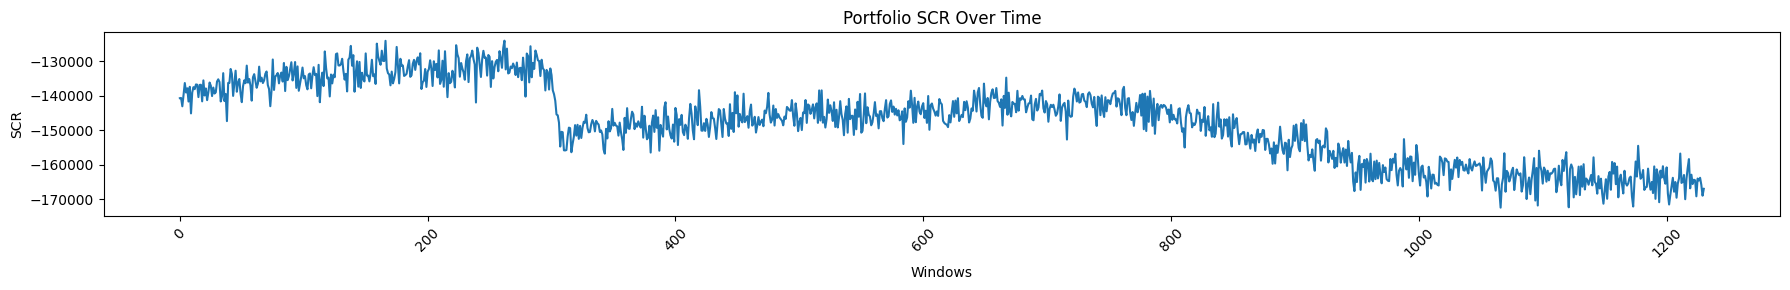

In [13]:
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

'''
plt.figure(figsize=(18, 3))
plt.plot(test_returns_df.index[:-3], scr_values, linestyle='-')
plt.xlabel("Windows")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()
'''

plt.figure(figsize=(18, 3))
plt.plot(scr_values, linestyle='-')
plt.xlabel("Windows")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

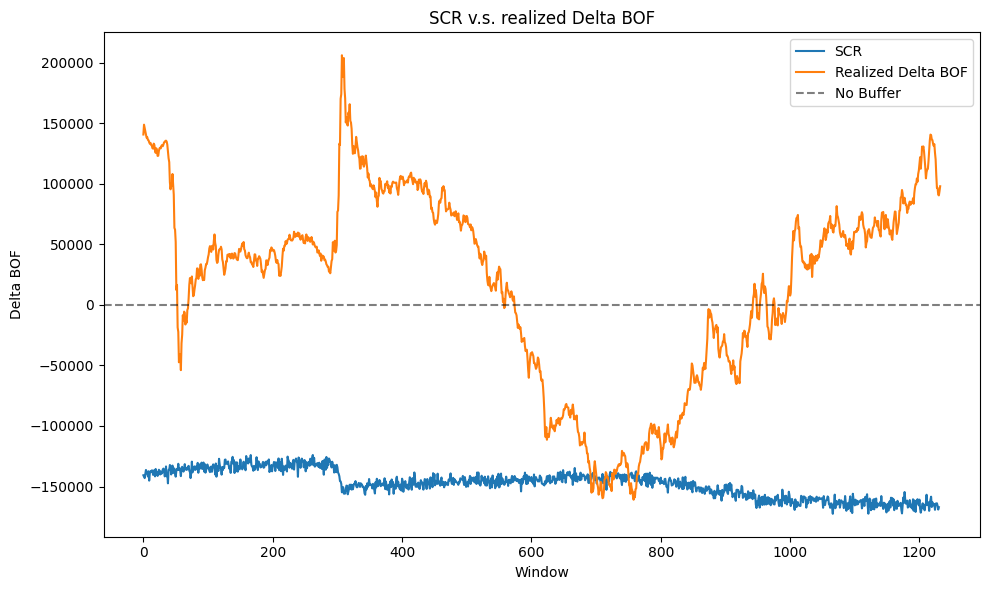

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(scr_values, linestyle='-', label='SCR')
plt.plot(realized_delta_bof_values_1, linestyle='-', label='Realized Delta BOF')

# Add a vertical dashed line - you can change the position as needed
plt.axhline(y=0, color='black', linestyle='--', label='No Buffer', alpha=0.5)

plt.xlabel("Window")
plt.ylabel("Delta BOF")
plt.title("SCR v.s. realized Delta BOF")
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()

In [15]:
count = 0
indicies = [0]
for i in range(len(realized_delta_bof_values_1[:-2])):
  if realized_delta_bof_values_1[i] < scr_values[i]:
    count += 1
    indicies.append(i)
count, indicies

(38,
 [0,
  692,
  693,
  694,
  695,
  696,
  702,
  703,
  704,
  705,
  706,
  707,
  708,
  709,
  710,
  711,
  712,
  713,
  714,
  717,
  720,
  721,
  722,
  723,
  724,
  725,
  727,
  751,
  752,
  753,
  754,
  755,
  756,
  757,
  758,
  759,
  760,
  761,
  762])

In [16]:
len(realized_delta_bof_values_1[:-2]), len(scr_values)

(1231, 1231)

In [17]:
df_scr = pd.DataFrame({
    "Realized_Delta_BOF": realized_delta_bof_values_1[:-2],
    'SCR_Values': scr_values
})

# Save to Google Drive (adjust path as needed)
df_scr.to_csv('drive/MyDrive/MasterThesis/esg_clayton.csv', index=False)
print("SCR values saved to Google Drive")

SCR values saved to Google Drive


In [ ]:
#evaluate_risk_metrics(scr_values, realized_delta_bof_values_1)